In [1]:
import pandas as pd
import numpy as np
import os
import tsfresh
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import tensorflow as tf
import seaborn as sns
from datetime import datetime

import os

import matplotlib.pyplot as plt

# keras goodies
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv1D, Dropout, MaxPooling1D, BatchNormalization, Conv2D, Bidirectional, LSTM, TimeDistributed
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras import metrics as kmetrics
import tensorflow.keras.backend as K

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate

In [2]:
window_size = 25
tf.random.set_seed(1)
np.random.seed(1)

## Getting the data

Before you run this, make sure that you have generated a sliding_windows file by running 01_sliding_windows.

In [3]:
data_path = '../data/'

In [162]:
# clean_final_sliding_windows_thingy = pd.read_csv(data_path + '/clean_sliding_windows_Thingy_smooth0_smallest25_size25_step25.csv')
clean_final_sliding_windows_respeck = pd.read_csv(data_path + '/clean_sliding_windows_Respeck_smooth0_smallest25_size25_step25.csv')


In [141]:
final_sliding_windows_thingy = pd.read_csv(data_path + '/sliding_windows_Thingy_smooth0_smallest25_size25_step25.csv')
final_sliding_windows_respeck = pd.read_csv(data_path + '/sliding_windows_Respeck_smooth0_smallest25_size25_step25.csv')

smooth3_final_sliding_windows_respeck = pd.read_csv(data_path + '/sliding_windows_Respeck_smooth3_smallest25_size25_step25.csv')
smooth3_final_sliding_windows_thingy = pd.read_csv(data_path + '/sliding_windows_Thingy_smooth3_smallest25_size25_step25.csv')

smooth5_final_sliding_windows_respeck = pd.read_csv(data_path + '/sliding_windows_Respeck_smooth5_smallest25_size25_step25.csv')
smooth5_final_sliding_windows_thingy = pd.read_csv(data_path + '/sliding_windows_Thingy_smooth5_smallest25_size25_step25.csv')

smooth7_final_sliding_windows_respeck = pd.read_csv(data_path + '/sliding_windows_Respeck_smooth7_smallest25_size25_step25.csv')
smooth7_final_sliding_windows_thingy = pd.read_csv(data_path + '/sliding_windows_Thingy_smooth7_smallest25_size25_step25.csv')

In [5]:
smooth9_final_sliding_windows_respeck = pd.read_csv(data_path + '/sliding_windows_Respeck_smooth9_smallest25_size25_step25.csv')
smooth9_final_sliding_windows_thingy = pd.read_csv(data_path + '/sliding_windows_Thingy_smooth9_smallest25_size25_step25.csv')

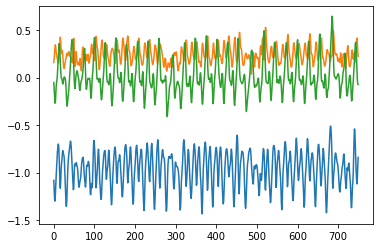

In [6]:
def plot_by_id(df, i): 
    plot_recording = df[df['recording_id'] == i]
    plot_recording = plot_recording.reset_index()
    plt.plot(plot_recording.index, plot_recording['accel_x'])
    plt.plot(plot_recording.index, plot_recording['accel_y'])
    plt.plot(plot_recording.index, plot_recording['accel_z'])
    
# plot_by_id(final_sliding_windows_respeck, 'Respeck_s1541031_Climbing stairs_06-10-2021_11-25-43')
plot_by_id(smooth7_final_sliding_windows_thingy, 'Thingy_s1541031_Climbing stairs_06-10-2021_11-27-07')

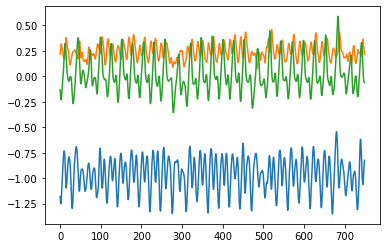

In [7]:
# plot_by_id(smooth7_final_sliding_windows_respeck, 'Respeck_s1541031_Climbing stairs_06-10-2021_11-25-43')
plot_by_id(smooth9_final_sliding_windows_thingy, 'Thingy_s1541031_Climbing stairs_06-10-2021_11-27-07')

## Some definitions

### Prepping the CNN model

In [8]:
def prep_cnn():
    print("Prepping CNN...")
    
    filters = 64
    kernel_size = 3
    n_features = 6
    activation ='relu'
    n_classes = len(class_labels)
    #filters = [3, 7, 11]

    model = Sequential()

    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='linear', 
                     input_shape=(window_size, n_features)))
    model.add(BatchNormalization())
    model.add(Activation(activation))

    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='linear'))
    model.add(BatchNormalization())
    model.add(Activation(activation))

    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='linear'))
    model.add(BatchNormalization())
    model.add(Activation(activation))

    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))

    #model.summary()
    
    model.compile(
    optimizer=optimizers.Adam(lr=0.001),
    loss='categorical_crossentropy',
    metrics = ['accuracy'])
    
    print("CNN prepped.")
    
    return model

In [62]:
# Wan et al. also used sinwod size 25, good for borrowing arch

def wan_cnn(f=64, kernels = [7,3,1], strides=3, save_to=None):
    """The kernel_sizes of each convolutional layer and pooling layer are 7, 3 and 1, 
    and the convolution depth (depth_size) is 64 steps, stride_size= 3, and batch_size= 64. 
    The number of hidden units in the fully connected layer is 512. During the training, 
    we used a dropout layer with the following parameters to prevent overfitting: 0.1, 0.25 and 0.5."""
    
    dropouts = [0.1,0.25,0.5]
    n_features = 6
    n_classes = len(class_labels)
    
    model = Sequential()

    model.add(Conv1D(filters=f, kernel_size=kernels[0],
                     input_shape=(window_size, n_features),))
    #They don't mention activation method
#     model.add(MaxPooling1D(strides=strides))
    model.add(MaxPooling1D())
    model.add(Dropout(dropouts[0]))
    
    model.add(Conv1D(filters=f, kernel_size=kernels[1]))
    model.add(MaxPooling1D())
    model.add(Dropout(dropouts[1]))
    
    model.add(Conv1D(filters=f, kernel_size=kernels[2]))
    model.add(MaxPooling1D())
    model.add(Dropout(dropouts[2]))
    
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Dense(n_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=0.001), metrics=['accuracy'])
    
    #save_to_models_comparisons('wan_et_al.txt', model.summary())
    print(model.summary())
    
    return model

In [142]:
def promising_cnn(filters=64, kernel_size=3, lr=0.001):
    n_features = 6
    activation ='relu'
    n_classes = len(class_labels)

    model = Sequential()

    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation=activation, 
                     input_shape=(window_size, n_features)))
    model.add(MaxPooling1D())
    model.add(BatchNormalization())
    model.add(Activation(activation))

    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation=activation))
    model.add(MaxPooling1D())
    model.add(BatchNormalization())
    model.add(Activation(activation))

    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation=activation))
    #model.add(MaxPooling1D())
    model.add(BatchNormalization())
    model.add(Activation(activation))

    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))

    model.summary()

    model.compile(
            optimizer=optimizers.Adam(lr=lr),
            loss='categorical_crossentropy',
            metrics = ['accuracy'])
    
    return model

In [11]:
def promising_cnn_tinkering(filters=64, kernel_size=3):
    filters = filters
    kernel_size = kernel_size
    n_features = 6
    activation ='relu'
    n_classes = len(class_labels)

    model = Sequential()

    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation=activation, 
                     input_shape=(window_size, n_features)))
    model.add(MaxPooling1D())

    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation=activation))
    model.add(MaxPooling1D())

    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation=activation))
    model.add(MaxPooling1D())

    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))

    model.summary()

    model.compile(
            optimizer=optimizers.Adam(lr=0.001),
            loss='categorical_crossentropy',
            metrics = ['accuracy'])
    
    return model

In [12]:
def try_lstm(lstm_units=128, nn_units=128, dropout=0.5, learning_rate=0.01):
    n_features = 6
    n_classes = len(class_labels)
    
    model = Sequential()
    model.add(
        Bidirectional(
          LSTM(
              units=lstm_units,
              input_shape=(window_size, n_features)
          )
        )
    )
    model.add(Dropout(rate=dropout))
    model.add(Dense(units=nn_units, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))

    model.compile(
      loss='categorical_crossentropy',
      optimizer=optimizers.Adam(lr=learning_rate),
      metrics=['acc']
    )
    
    return model

In [13]:
def cnn_lstm():
    filters = 64
    kernel_size = 3
    n_features = 6
    activation ='relu'
    n_classes = len(class_labels)
    
    # define CNN model
    cnn = Sequential()
    cnn.add(Conv1D(filters=filters, kernel_size=kernel_size, activation=activation, 
                     input_shape=(window_size, n_features)))
    cnn.add(MaxPooling1D())
    cnn.add(Flatten())
    
    # define LSTM model
    model = Sequential()
    model.add(TimeDistributed(cnn))
    """
    model.add(
        Bidirectional(
          LSTM(
              units=128,
              input_shape=(1,704)
          )
        )
    )
    model.add(Dropout(rate=0.5))
    model.add(Dense(units=128, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))
    
    model.compile(
      loss='categorical_crossentropy',
      optimizer='adam',
      metrics=['acc']
    )
    """
    
    return cnn

In [14]:
def try_cnn_lstm():
    filters = 64
    kernel_size = 3
    n_features = 6
    activation ='relu'
    n_classes = len(class_labels)
    
    model = Sequential([
          Conv1D(filters=filters, kernel_size=kernel_size, activation=activation, 
                     input_shape=(window_size, n_features)),
        MaxPooling1D(),
        Conv1D(filters=filters, kernel_size=kernel_size, activation=activation),
        MaxPooling1D(),
           Bidirectional(LSTM(units=128)),
        Flatten(),
        Dropout(rate=0.5),
          Dense(units=128, activation='relu'),
        Dense(n_classes, activation='softmax')])
    
    model.compile(
      loss='categorical_crossentropy',
      optimizer='adam',
      metrics=['acc']
    )
    
    return model

In [15]:
# multi-headed cnn model
# https://machinelearningmastery.com/cnn-models-for-human-activity-recognition-time-series-classification/

def multi_head_cnn(trainX, trainy, testX, testy, filters=64, kernel_size=[3,5,11], dropout=0.5, lr=0.001):
#     k1_size, k2_size, k3_size = 3, 5, 11 # 56 / 86
#     k1_size, k2_size, k3_size = 2, 3, 7 # 59 / 89
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    # head 1
    inputs1 = Input(shape=(n_timesteps,n_features))
    conv1 = Conv1D(filters=filters, kernel_size=kernel_size[0], activation='relu')(inputs1)
    drop1 = Dropout(dropout)(conv1)
    pool1 = MaxPooling1D(pool_size=2)(drop1)
    flat1 = Flatten()(pool1)
    # head 2
    inputs2 = Input(shape=(n_timesteps,n_features))
    conv2 = Conv1D(filters=filters, kernel_size=kernel_size[1], activation='relu')(inputs2)
    drop2 = Dropout(dropout)(conv2)
    pool2 = MaxPooling1D(pool_size=2)(drop2)
    flat2 = Flatten()(pool2)
    # head 3
    inputs3 = Input(shape=(n_timesteps,n_features))
    conv3 = Conv1D(filters=filters, kernel_size=kernel_size[2], activation='relu')(inputs3)
    drop3 = Dropout(dropout)(conv3)
    pool3 = MaxPooling1D(pool_size=2)(drop3)
    flat3 = Flatten()(pool3)
    # merge
    merged = concatenate([flat1, flat2, flat3])
    # interpretation
    dense1 = Dense(100, activation='relu')(merged)
    outputs = Dense(n_outputs, activation='softmax')(dense1)
    model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
    
    model.summary()
    
    model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=lr), metrics=['accuracy'])
    
    return model

In [16]:
def save_to_models_comparisons(save_to, text):
    model_dir = 'models/comparisons/'
    
    if not os.path.isdir(model_dir):
        os.makedirs(model_dir)
        
    f = open(model_dir + save_to, "a")
    f.write(text)
    f.close()

### Format the input

Format data into windows - make (window_size,6) inputs

In [17]:
columns_of_interest = ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']

In [18]:
class_labels = {
    'Sitting': 0,
    'Sitting bent forward': 1,
    'Sitting bent backward': 2,
    'Standing': 3,
    'Lying down left': 4,
    'Lying down right': 5,
    'Lying down on stomach': 6,
    'Lying down on back': 7,
    'Walking at normal speed': 8,
    'Running': 9,
    'Climbing stairs': 10,
    'Descending stairs': 11,
    'Desk work': 12,
    'Movement': 13,
    'Falling on knees': 14,
    'Falling on the back': 15,
    'Falling on the left': 16,
    'Falling on the right': 17
}

In [19]:
def format_data(X_train_full, y_train_full, X_test_full, y_test_full):
    
    print("Formatting data...")
    # Keep only the classes of interest
#     X_train_full = X_train_full[y_train_full['activity_type'].isin(class_labels.keys())]
#     X_test_full = X_test_full[y_test_full['activity_type'].isin(class_labels.keys())]
#     y_train_full = y_train_full[y_train_full['activity_type'].isin(class_labels.keys())]
#     y_test_full = y_test_full[y_test_full['activity_type'].isin(class_labels.keys())]

    # Create the y ones
    y_train = y_train_full.groupby("window_id")[['activity_type']].agg(np.min).replace(class_labels)['activity_type'].values
    y_test = y_test_full.groupby("window_id")[['activity_type']].agg(np.min).replace(class_labels)['activity_type'].values
    y_train = np.asarray(pd.get_dummies(y_train), dtype=np.float32)
    y_test = np.asarray(pd.get_dummies(y_test), dtype=np.float32)
    
    X_train = []
    X_test = []

    for window_id, group in X_train_full.groupby('window_id'):
        #print(f"window_id = {window_id}")

        shape = group[columns_of_interest].values.shape
        #print(f"shape = {shape}")
        if shape == (window_size, len(columns_of_interest)):
            X_train.append(group[columns_of_interest].values)

    for window_id, group in X_test_full.groupby('window_id'):
        #print(f"window_id = {window_id}")

        shape = group[columns_of_interest].values.shape
        #print(f"shape = {shape}")

        X_test.append(group[columns_of_interest].values)

    X_train = np.asarray(X_train)#, dtype=object)
    X_test = np.asarray(X_test)#, dtype=object)
    
    print(np.shape(X_train))
    print(np.shape(X_test))

    print(np.shape(y_train))
    print(np.shape(y_test))
    
    print("Data formatted.")
    return X_train, y_train, X_test, y_test

In [143]:
def format_all_data(X_train_full, y_train_full):
    # to be used when we only want a training set not test set
    
    print("Formatting data...")
    # Keep only the classes of interest
#     X_train_full = X_train_full[y_train_full['activity_type'].isin(class_labels.keys())]
#     y_train_full = y_train_full[y_train_full['activity_type'].isin(class_labels.keys())]

    # Create the y ones
    y_train = y_train_full.groupby("window_id")[['activity_type']].agg(np.min).replace(class_labels)['activity_type'].values
    y_train = np.asarray(pd.get_dummies(y_train), dtype=np.float32)
    
    X_train = []

    for window_id, group in X_train_full.groupby('window_id'):
        #print(f"window_id = {window_id}")

        shape = group[columns_of_interest].values.shape
        #print(f"shape = {shape}")
        if shape == (window_size,len(columns_of_interest)):
            X_train.append(group[columns_of_interest].values)

    X_train = np.asarray(X_train)#, dtype=object)
    
    print(np.shape(X_train))
    print(np.shape(y_train))
    
    print("Data formatted.")
    return X_train, y_train

### Accuracy of the model (+ on subset)

In [21]:
# This is used for grouping the predictions into subsets
activity_groups = {
 'Sitting/Standing': [0,1,2,3,12], # including desk work
 'Lying': [4,5,6,7],
 'Walking': [8,10,11,13], # I include up and down stairs in this one + movement
 'Running': [9],
 'Falling': [14,15,16,17]
}
    
def group_y(y):
    grouped_y = []
    for yy in y:
        group = [i for i,v in enumerate(activity_groups.values()) if yy in v][0]
        grouped_y.append(group)
    return grouped_y

In [22]:
def evaluate(y_true_labels, y_pred_labels, save_to=None):
    print('\n')
    print("*" * 80)
    print("Classification report")
    print("*" * 80)
    print(classification_report(y_true_labels, y_pred_labels))
    
    # compute accuracy of the subset of activities 
    grouped_y_true_labels = group_y(y_true_labels)
    grouped_y_pred_labels = group_y(y_pred_labels)

    print('\n')
    print("*" * 80)
    print("Classification report")
    print("*" * 80)
    print(classification_report(grouped_y_true_labels, grouped_y_pred_labels))

In [23]:
def confusion_mat(y_true_labels, y_pred_labels):
    confusion_matrix = tf.math.confusion_matrix(
        y_true_labels, y_pred_labels, num_classes=None, weights=None, dtype=tf.dtypes.int32,
        name=None
    )
    
    sns.heatmap(confusion_matrix, annot=True, xticklabels=class_labels.keys(), yticklabels=class_labels.keys())

## Without Cross-validation for development

In [24]:
def prep_dev_data(final_sliding_windows):

    # split data into training and test sets (split by subject)

    subjects = final_sliding_windows['subject_id'].unique()

    train_subjects, test_subjects = train_test_split(subjects, test_size=0.2, train_size=0.8)

    X_train_full = final_sliding_windows[final_sliding_windows['subject_id'].isin(train_subjects)][['window_id'] + columns_of_interest]
    y_train_full = final_sliding_windows[final_sliding_windows['subject_id'].isin(train_subjects)][['window_id'] + ['activity_type']]
    
    X_test_full = final_sliding_windows[final_sliding_windows['subject_id'].isin(test_subjects)][['window_id'] + columns_of_interest]
    y_test_full = final_sliding_windows[final_sliding_windows['subject_id'].isin(test_subjects)][['window_id'] + ['activity_type']]
    
    # format the data
    X_train, y_train, X_test, y_test = format_data(X_train_full, y_train_full, X_test_full, y_test_full)
    
    return X_train, y_train, X_test, y_test

In [144]:
def train_dev_model(model, X_train, y_train, batch_size=100, epochs=10):

    # train the model 
    model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs)
    
    return model

In [167]:
# Prep data
X_train, y_train, X_test, y_test = prep_dev_data(final_sliding_windows_respeck)

Formatting data...
(19224, 25, 6)
(5055, 25, 6)
(19224, 18)
(5055, 18)
Data formatted.


In [168]:
# # Prep data
# X_train, y_train, X_test, y_test = prep_dev_data(final_sliding_windows_thingy)

# prepare the model
model = promising_cnn(filters=128, kernel_size=2, lr=0.001)
# model = multi_head_cnn(X_train, y_train, X_test, y_test)

# Train 
model = train_dev_model(model, X_train, y_train, batch_size=64, epochs=10)
#train multi head cnn - 3 inputs
# model = train_dev_model(model, [X_train, X_train, X_train], y_train, batch_size=64, epochs=5)    

# Test the model
y_pred_ohe = model.predict(X_test)
# test multi head cnn - 3 inputs
# y_pred_ohe = model.predict([X_test, X_test, X_test])
y_pred_labels = np.argmax(y_pred_ohe, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

evaluate(y_true_labels, y_pred_labels)

Model: "sequential_127"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_378 (Conv1D)          (None, 24, 128)           1664      
_________________________________________________________________
max_pooling1d_274 (MaxPoolin (None, 12, 128)           0         
_________________________________________________________________
batch_normalization_309 (Bat (None, 12, 128)           512       
_________________________________________________________________
activation_309 (Activation)  (None, 12, 128)           0         
_________________________________________________________________
conv1d_379 (Conv1D)          (None, 11, 128)           32896     
_________________________________________________________________
max_pooling1d_275 (MaxPoolin (None, 5, 128)            0         
_________________________________________________________________
batch_normalization_310 (Bat (None, 5, 128)         

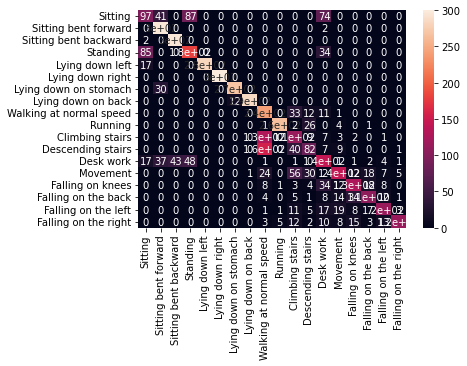

In [217]:
confusion_mat(y_true_labels, y_pred_labels)

## Train baseline model on ALL data

In [148]:
# Note: On Thingy
X = final_sliding_windows_thingy[['window_id'] + columns_of_interest]
y = final_sliding_windows_thingy[['window_id'] + ['activity_type']]

# format the data
X_train, y_train = format_all_data(X, y)
   
# prepare the CNN
model = promising_cnn(filters=64, kernel_size=2, lr=0.001)

# train the model 
thingy_promising_cnn_model = train_dev_model(model, X_train, y_train, batch_size=64, epochs=10)

Formatting data...
(24050, 25, 6)
(24050, 18)
Data formatted.
Model: "sequential_124"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_369 (Conv1D)          (None, 24, 64)            832       
_________________________________________________________________
max_pooling1d_268 (MaxPoolin (None, 12, 64)            0         
_________________________________________________________________
batch_normalization_300 (Bat (None, 12, 64)            256       
_________________________________________________________________
activation_300 (Activation)  (None, 12, 64)            0         
_________________________________________________________________
conv1d_370 (Conv1D)          (None, 11, 64)            8256      
_________________________________________________________________
max_pooling1d_269 (MaxPoolin (None, 5, 64)             0         
________________________________________________________

## Leave-One-Subject-Out Cross Validation

In [49]:
def get_loocv(final_sliding_windows, n=6):

    loocv = LeaveOneGroupOut()

    # # UNCOMMENT TO LEAVE ONE SUBJECT OUT####
    # # group by subject id so that one subject is left out each time
    # groups = final_sliding_windows['subject_id']
    # ########################################

    # UNCOMMENT TO LEAVE (48 / N) SUBJECTS OUT####
    # n must be a factor of 48 (there are 48 subjects in the dataset)
    #n = 6
    subj_group_mapping = {}
    for i, subj_id in enumerate(final_sliding_windows['subject_id'].unique()):
        subj_group_mapping[subj_id] = i % n
    groups = [ subj_group_mapping[subj_id] for subj_id in final_sliding_windows['subject_id'] ]
    ########################################

    X = final_sliding_windows[['window_id'] + columns_of_interest]
    y = final_sliding_windows[['window_id'] + ['activity_type']]

    # how many different subjects
    loocv.get_n_splits(X, y, groups)
    
    return loocv, X, y, groups

In [139]:
def run_cross_val(final_sliding_windows, model_setup, params={}, n=4,  batch_size=32, epochs=10):
    loocv, X, y, groups = get_loocv(final_sliding_windows, n=n)

    y_pred_labels = np.empty(shape=(0,))
    y_true_labels = np.empty(shape=(0,))
    
#     trained_models = [] # For epoch experiments

    # this gives a train/test split that leaves one subject out in each iteration
    for i, (train_index, test_index) in enumerate(loocv.split(X, y, groups)):
        print("Starting iteration " + str(i) + ' of ' + str(n))

        X_train_full, X_test_full = X.iloc[train_index], X.iloc[test_index]
        y_train_full, y_test_full = y.iloc[train_index], y.iloc[test_index]

        X_train, y_train, X_test, y_test = format_data(X_train_full, y_train_full, X_test_full, y_test_full)

        model = model_setup(**params)

        print("Training...")
        trained = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs)
#         trained_models.append(trained)
        
        # stats
        y_pred_ohe = model.predict(X_test)
        y_pred_labels = np.concatenate([y_pred_labels, np.argmax(y_pred_ohe, axis=1)])
        y_true_labels = np.concatenate([y_true_labels, np.argmax(y_test, axis=1)])

        print(y_pred_labels.shape)
        print(y_true_labels.shape)

    evaluate(y_true_labels, y_pred_labels)
    
    confusion_mat(y_true_labels, y_pred_labels)
    
    return y_true_labels, y_pred_labels

Starting iteration 0 of 48
Formatting data...
(23764, 25, 6)
(515, 25, 6)
(23764, 18)
(515, 18)
Data formatted.
Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_81 (Conv1D)           (None, 24, 128)           1664      
_________________________________________________________________
max_pooling1d_76 (MaxPooling (None, 12, 128)           0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 12, 128)           512       
_________________________________________________________________
activation_12 (Activation)   (None, 12, 128)           0         
_________________________________________________________________
conv1d_82 (Conv1D)           (None, 11, 128)           32896     
_________________________________________________________________
max_pooling1d_77 (MaxPooling (None, 5, 128)            0         
_______

Epoch 1/10
372/372 [==============================] - 12s 27ms/step - loss: 2.3855 - accuracy: 0.2338
Epoch 2/10
372/372 [==============================] - 12s 33ms/step - loss: 1.7074 - accuracy: 0.3538
Epoch 3/10
372/372 [==============================] - 13s 34ms/step - loss: 1.3630 - accuracy: 0.4738
Epoch 4/10
372/372 [==============================] - 11s 30ms/step - loss: 1.0671 - accuracy: 0.6359
Epoch 5/10
372/372 [==============================] - 12s 31ms/step - loss: 0.9573 - accuracy: 0.6623
Epoch 6/10
372/372 [==============================] - 9s 25ms/step - loss: 0.8991 - accuracy: 0.6836
Epoch 7/10
372/372 [==============================] - 11s 28ms/step - loss: 0.8252 - accuracy: 0.7026
Epoch 8/10
372/372 [==============================] - 8s 22ms/step - loss: 0.7924 - accuracy: 0.7122
Epoch 9/10
372/372 [==============================] - 10s 27ms/step - loss: 0.7499 - accuracy: 0.7254
Epoch 10/10
372/372 [==============================] - 12s 33ms/step - loss: 0.6968 

372/372 [==============================] - 12s 28ms/step - loss: 2.4046 - accuracy: 0.2322
Epoch 2/10
372/372 [==============================] - 11s 28ms/step - loss: 1.6551 - accuracy: 0.3640
Epoch 3/10
372/372 [==============================] - 8s 21ms/step - loss: 1.3659 - accuracy: 0.4562
Epoch 4/10
372/372 [==============================] - 9s 25ms/step - loss: 1.1064 - accuracy: 0.6018
Epoch 5/10
372/372 [==============================] - 10s 27ms/step - loss: 0.9934 - accuracy: 0.6475
Epoch 6/10
372/372 [==============================] - 9s 23ms/step - loss: 0.9076 - accuracy: 0.6730
Epoch 7/10
372/372 [==============================] - 9s 25ms/step - loss: 0.8692 - accuracy: 0.6866
Epoch 8/10
372/372 [==============================] - 8s 22ms/step - loss: 0.8029 - accuracy: 0.7102
Epoch 9/10
372/372 [==============================] - 9s 25ms/step - loss: 0.7592 - accuracy: 0.7221
Epoch 10/10
372/372 [==============================] - 8s 22ms/step - loss: 0.7271 - accuracy: 0.73

372/372 [==============================] - 12s 29ms/step - loss: 2.3949 - accuracy: 0.2317
Epoch 2/10
372/372 [==============================] - 10s 28ms/step - loss: 1.6806 - accuracy: 0.3638
Epoch 3/10
372/372 [==============================] - 10s 28ms/step - loss: 1.2240 - accuracy: 0.5509
Epoch 4/10
372/372 [==============================] - 11s 28ms/step - loss: 1.0205 - accuracy: 0.6465
Epoch 5/10
372/372 [==============================] - 12s 33ms/step - loss: 0.9076 - accuracy: 0.6834
Epoch 6/10
372/372 [==============================] - 12s 32ms/step - loss: 0.8465 - accuracy: 0.7000
Epoch 7/10
372/372 [==============================] - 10s 28ms/step - loss: 0.7936 - accuracy: 0.7194
Epoch 8/10
372/372 [==============================] - 11s 30ms/step - loss: 0.7418 - accuracy: 0.7324
Epoch 9/10
372/372 [==============================] - 10s 28ms/step - loss: 0.7008 - accuracy: 0.7402
Epoch 10/10
372/372 [==============================] - 10s 28ms/step - loss: 0.6795 - accurac

372/372 [==============================] - 12s 28ms/step - loss: 2.3931 - accuracy: 0.2275
Epoch 2/10
372/372 [==============================] - 11s 29ms/step - loss: 1.5267 - accuracy: 0.3939
Epoch 3/10
372/372 [==============================] - 10s 28ms/step - loss: 1.3425 - accuracy: 0.4759
Epoch 4/10
372/372 [==============================] - 10s 28ms/step - loss: 1.0188 - accuracy: 0.6463
Epoch 5/10
372/372 [==============================] - 11s 29ms/step - loss: 0.9407 - accuracy: 0.6659
Epoch 6/10
372/372 [==============================] - 11s 29ms/step - loss: 0.8864 - accuracy: 0.6822
Epoch 7/10
372/372 [==============================] - 10s 28ms/step - loss: 0.8351 - accuracy: 0.7026
Epoch 8/10
372/372 [==============================] - 11s 30ms/step - loss: 0.7753 - accuracy: 0.7183
Epoch 9/10
372/372 [==============================] - 10s 28ms/step - loss: 0.7386 - accuracy: 0.7338
Epoch 10/10
372/372 [==============================] - 10s 28ms/step - loss: 0.6847 - accurac

Epoch 1/10
372/372 [==============================] - 13s 29ms/step - loss: 2.3803 - accuracy: 0.2277
Epoch 2/10
372/372 [==============================] - 11s 29ms/step - loss: 1.7986 - accuracy: 0.3361
Epoch 3/10
372/372 [==============================] - 10s 28ms/step - loss: 1.4201 - accuracy: 0.4489
Epoch 4/10
372/372 [==============================] - 11s 29ms/step - loss: 1.2441 - accuracy: 0.5397
Epoch 5/10
372/372 [==============================] - 12s 31ms/step - loss: 0.9695 - accuracy: 0.6625
Epoch 6/10
372/372 [==============================] - 11s 29ms/step - loss: 0.8938 - accuracy: 0.6793
Epoch 7/10
372/372 [==============================] - 11s 29ms/step - loss: 0.8423 - accuracy: 0.6968
Epoch 8/10
372/372 [==============================] - 10s 28ms/step - loss: 0.7725 - accuracy: 0.7204
Epoch 9/10
372/372 [==============================] - 10s 27ms/step - loss: 0.7369 - accuracy: 0.7302
Epoch 10/10
372/372 [==============================] - 11s 28ms/step - loss: 0.708

372/372 [==============================] - 13s 32ms/step - loss: 2.4009 - accuracy: 0.2350
Epoch 2/10
372/372 [==============================] - 10s 27ms/step - loss: 1.7495 - accuracy: 0.3476
Epoch 3/10
372/372 [==============================] - 10s 28ms/step - loss: 1.2902 - accuracy: 0.5110
Epoch 4/10
372/372 [==============================] - 11s 28ms/step - loss: 1.1118 - accuracy: 0.6003
Epoch 5/10
372/372 [==============================] - 12s 32ms/step - loss: 0.9485 - accuracy: 0.6680
Epoch 6/10
372/372 [==============================] - 10s 28ms/step - loss: 0.8743 - accuracy: 0.6897
Epoch 7/10
372/372 [==============================] - 10s 28ms/step - loss: 0.8244 - accuracy: 0.7055
Epoch 8/10
372/372 [==============================] - 10s 28ms/step - loss: 0.7785 - accuracy: 0.7188
Epoch 9/10
372/372 [==============================] - 11s 29ms/step - loss: 0.7415 - accuracy: 0.7227
Epoch 10/10
372/372 [==============================] - 11s 28ms/step - loss: 0.7048 - accurac

372/372 [==============================] - 12s 29ms/step - loss: 2.3909 - accuracy: 0.2291
Epoch 2/10
372/372 [==============================] - 11s 30ms/step - loss: 1.6225 - accuracy: 0.3801
Epoch 3/10
372/372 [==============================] - 10s 27ms/step - loss: 1.3868 - accuracy: 0.4550
Epoch 4/10
372/372 [==============================] - 10s 27ms/step - loss: 1.1640 - accuracy: 0.5770
Epoch 5/10
372/372 [==============================] - 11s 30ms/step - loss: 1.0657 - accuracy: 0.6216
Epoch 6/10
372/372 [==============================] - 11s 30ms/step - loss: 0.9311 - accuracy: 0.6728
Epoch 7/10
372/372 [==============================] - 10s 28ms/step - loss: 0.8593 - accuracy: 0.6954
Epoch 8/10
372/372 [==============================] - 10s 27ms/step - loss: 0.8146 - accuracy: 0.7142
Epoch 9/10
372/372 [==============================] - 11s 28ms/step - loss: 0.7908 - accuracy: 0.7185
Epoch 10/10
372/372 [==============================] - 11s 30ms/step - loss: 0.7363 - accurac

371/371 [==============================] - 12s 28ms/step - loss: 2.3665 - accuracy: 0.2294
Epoch 2/10
371/371 [==============================] - 11s 29ms/step - loss: 1.6855 - accuracy: 0.3643
Epoch 3/10
371/371 [==============================] - 11s 29ms/step - loss: 1.3250 - accuracy: 0.4866
Epoch 4/10
371/371 [==============================] - 11s 29ms/step - loss: 1.1188 - accuracy: 0.5914
Epoch 5/10
371/371 [==============================] - 11s 29ms/step - loss: 0.9462 - accuracy: 0.6663
Epoch 6/10
371/371 [==============================] - 11s 30ms/step - loss: 0.8729 - accuracy: 0.6902
Epoch 7/10
371/371 [==============================] - 11s 29ms/step - loss: 0.8342 - accuracy: 0.6974
Epoch 8/10
371/371 [==============================] - 11s 30ms/step - loss: 0.7914 - accuracy: 0.7088
Epoch 9/10
371/371 [==============================] - 10s 28ms/step - loss: 0.7647 - accuracy: 0.7171
Epoch 10/10
371/371 [==============================] - 10s 28ms/step - loss: 0.7147 - accurac

372/372 [==============================] - 13s 29ms/step - loss: 2.3702 - accuracy: 0.2304
Epoch 2/10
372/372 [==============================] - 11s 28ms/step - loss: 1.6474 - accuracy: 0.3757
Epoch 3/10
372/372 [==============================] - 11s 29ms/step - loss: 1.2418 - accuracy: 0.5292
Epoch 4/10
372/372 [==============================] - 11s 30ms/step - loss: 1.0343 - accuracy: 0.6337
Epoch 5/10
372/372 [==============================] - 10s 28ms/step - loss: 0.9293 - accuracy: 0.6685
Epoch 6/10
372/372 [==============================] - 10s 26ms/step - loss: 0.8655 - accuracy: 0.6912
Epoch 7/10
372/372 [==============================] - 11s 29ms/step - loss: 0.8039 - accuracy: 0.7097
Epoch 8/10
372/372 [==============================] - 10s 28ms/step - loss: 0.7528 - accuracy: 0.7214
Epoch 9/10
372/372 [==============================] - 9s 25ms/step - loss: 0.7044 - accuracy: 0.7425
Epoch 10/10
372/372 [==============================] - 10s 28ms/step - loss: 0.6766 - accuracy

372/372 [==============================] - 12s 27ms/step - loss: 2.4319 - accuracy: 0.2239
Epoch 2/10
372/372 [==============================] - 10s 28ms/step - loss: 1.6438 - accuracy: 0.3727
Epoch 3/10
372/372 [==============================] - 11s 28ms/step - loss: 1.3504 - accuracy: 0.4765
Epoch 4/10
372/372 [==============================] - 11s 30ms/step - loss: 1.0393 - accuracy: 0.6365
Epoch 5/10
372/372 [==============================] - 11s 30ms/step - loss: 0.9419 - accuracy: 0.6647
Epoch 6/10
372/372 [==============================] - 11s 29ms/step - loss: 0.8879 - accuracy: 0.6856
Epoch 7/10
372/372 [==============================] - 11s 30ms/step - loss: 0.8365 - accuracy: 0.6980
Epoch 8/10
372/372 [==============================] - 10s 28ms/step - loss: 0.7802 - accuracy: 0.7187
Epoch 9/10
372/372 [==============================] - 10s 28ms/step - loss: 0.7303 - accuracy: 0.7313
Epoch 10/10
372/372 [==============================] - 11s 29ms/step - loss: 0.6985 - accurac

374/374 [==============================] - 12s 28ms/step - loss: 2.3694 - accuracy: 0.2371
Epoch 2/10
374/374 [==============================] - 10s 28ms/step - loss: 1.7013 - accuracy: 0.3544
Epoch 3/10
374/374 [==============================] - 10s 27ms/step - loss: 1.3584 - accuracy: 0.4668
Epoch 4/10
374/374 [==============================] - 10s 27ms/step - loss: 1.0867 - accuracy: 0.6173
Epoch 5/10
374/374 [==============================] - 10s 26ms/step - loss: 0.9379 - accuracy: 0.6748
Epoch 6/10
374/374 [==============================] - 10s 26ms/step - loss: 0.8673 - accuracy: 0.6957
Epoch 7/10
374/374 [==============================] - 11s 30ms/step - loss: 0.7882 - accuracy: 0.7134
Epoch 8/10
374/374 [==============================] - 11s 28ms/step - loss: 0.7569 - accuracy: 0.7271
Epoch 9/10
374/374 [==============================] - 11s 29ms/step - loss: 0.7086 - accuracy: 0.7373
Epoch 10/10
374/374 [==============================] - 11s 29ms/step - loss: 0.6580 - accurac

Epoch 1/10
372/372 [==============================] - 12s 27ms/step - loss: 2.4040 - accuracy: 0.2249
Epoch 2/10
372/372 [==============================] - 10s 28ms/step - loss: 1.7086 - accuracy: 0.3624
Epoch 3/10
372/372 [==============================] - 10s 28ms/step - loss: 1.4071 - accuracy: 0.4454
Epoch 4/10
372/372 [==============================] - 11s 29ms/step - loss: 1.1564 - accuracy: 0.5815
Epoch 5/10
372/372 [==============================] - 10s 28ms/step - loss: 0.9722 - accuracy: 0.6631
Epoch 6/10
372/372 [==============================] - 10s 27ms/step - loss: 0.8971 - accuracy: 0.6796
Epoch 7/10
372/372 [==============================] - 11s 28ms/step - loss: 0.8465 - accuracy: 0.6916
Epoch 8/10
372/372 [==============================] - 11s 29ms/step - loss: 0.8004 - accuracy: 0.7085
Epoch 9/10
372/372 [==============================] - 11s 30ms/step - loss: 0.7733 - accuracy: 0.7203
Epoch 10/10
372/372 [==============================] - 11s 29ms/step - loss: 0.725

372/372 [==============================] - 13s 31ms/step - loss: 2.3750 - accuracy: 0.2376
Epoch 2/10
372/372 [==============================] - 13s 35ms/step - loss: 1.6793 - accuracy: 0.3563
Epoch 3/10
372/372 [==============================] - 12s 31ms/step - loss: 1.2812 - accuracy: 0.5233
Epoch 4/10
372/372 [==============================] - 11s 29ms/step - loss: 1.0121 - accuracy: 0.6436
Epoch 5/10
372/372 [==============================] - 11s 29ms/step - loss: 0.9368 - accuracy: 0.6708
Epoch 6/10
372/372 [==============================] - 10s 28ms/step - loss: 0.9060 - accuracy: 0.6771
Epoch 7/10
372/372 [==============================] - 11s 28ms/step - loss: 0.8426 - accuracy: 0.6999
Epoch 8/10
372/372 [==============================] - 11s 29ms/step - loss: 0.8118 - accuracy: 0.7028
Epoch 9/10
372/372 [==============================] - 11s 29ms/step - loss: 0.7611 - accuracy: 0.7254
Epoch 10/10
372/372 [==============================] - 10s 28ms/step - loss: 0.7312 - accurac

372/372 [==============================] - 13s 29ms/step - loss: 2.4474 - accuracy: 0.2200
Epoch 2/10
372/372 [==============================] - 11s 29ms/step - loss: 1.7315 - accuracy: 0.3493
Epoch 3/10
372/372 [==============================] - 12s 31ms/step - loss: 1.3539 - accuracy: 0.4773
Epoch 4/10
372/372 [==============================] - 12s 33ms/step - loss: 1.0818 - accuracy: 0.6192
Epoch 5/10
372/372 [==============================] - 11s 29ms/step - loss: 0.9735 - accuracy: 0.6563
Epoch 6/10
372/372 [==============================] - 11s 29ms/step - loss: 0.8986 - accuracy: 0.6789
Epoch 7/10
372/372 [==============================] - 10s 28ms/step - loss: 0.8580 - accuracy: 0.6960
Epoch 8/10
372/372 [==============================] - 11s 28ms/step - loss: 0.7738 - accuracy: 0.7197
Epoch 9/10
372/372 [==============================] - 10s 28ms/step - loss: 0.7773 - accuracy: 0.7186
Epoch 10/10
372/372 [==============================] - 10s 28ms/step - loss: 0.7157 - accurac

Epoch 1/10
372/372 [==============================] - 13s 29ms/step - loss: 2.3877 - accuracy: 0.2356
Epoch 2/10
372/372 [==============================] - 10s 28ms/step - loss: 1.6308 - accuracy: 0.3698
Epoch 3/10
372/372 [==============================] - 10s 28ms/step - loss: 1.2817 - accuracy: 0.5181
Epoch 4/10
372/372 [==============================] - 10s 28ms/step - loss: 1.0237 - accuracy: 0.6406
Epoch 5/10
372/372 [==============================] - 11s 30ms/step - loss: 0.9482 - accuracy: 0.6700
Epoch 6/10
372/372 [==============================] - 11s 29ms/step - loss: 0.9053 - accuracy: 0.6816
Epoch 7/10
372/372 [==============================] - 11s 28ms/step - loss: 0.8464 - accuracy: 0.6977
Epoch 8/10
372/372 [==============================] - 10s 27ms/step - loss: 0.7901 - accuracy: 0.7158
Epoch 9/10
372/372 [==============================] - 11s 29ms/step - loss: 0.7662 - accuracy: 0.7221
Epoch 10/10
372/372 [==============================] - 11s 29ms/step - loss: 0.730



********************************************************************************
Classification report
********************************************************************************
              precision    recall  f1-score   support

           0       0.91      0.90      0.90      7062
           1       0.89      0.95      0.92      5716
           2       0.87      0.87      0.87      5675
           3       0.91      0.85      0.88      1424
           4       0.86      0.81      0.84      4402

    accuracy                           0.89     24279
   macro avg       0.89      0.88      0.88     24279
weighted avg       0.89      0.89      0.89     24279



ValueError: too many values to unpack (expected 2)

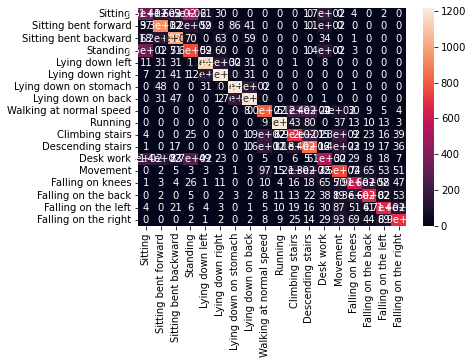

In [137]:
# DO NOT RERUN! save output!
# Running cross-val for promising cnn repseck 
params = {'filters':128, 'kernel_size':2, 'lr':0.001}
y_t, y_p = run_cross_val(final_sliding_windows_respeck, promising_cnn, params, epochs=10, n=48, batch_size=64)

Starting iteration 0 of 48
Formatting data...
(23533, 25, 6)
(517, 25, 6)
(23533, 18)
(517, 18)
Data formatted.
Model: "sequential_75"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_222 (Conv1D)          (None, 24, 64)            832       
_________________________________________________________________
max_pooling1d_170 (MaxPoolin (None, 12, 64)            0         
_________________________________________________________________
batch_normalization_153 (Bat (None, 12, 64)            256       
_________________________________________________________________
activation_153 (Activation)  (None, 12, 64)            0         
_________________________________________________________________
conv1d_223 (Conv1D)          (None, 11, 64)            8256      
_________________________________________________________________
max_pooling1d_171 (MaxPoolin (None, 5, 64)             0         
_______

Epoch 1/10
368/368 [==============================] - 7s 13ms/step - loss: 2.4458 - accuracy: 0.2208
Epoch 2/10
368/368 [==============================] - 5s 13ms/step - loss: 1.8054 - accuracy: 0.3511
Epoch 3/10
368/368 [==============================] - 5s 13ms/step - loss: 1.5491 - accuracy: 0.4282
Epoch 4/10
368/368 [==============================] - 5s 13ms/step - loss: 1.3185 - accuracy: 0.5089
Epoch 5/10
368/368 [==============================] - 5s 12ms/step - loss: 1.2434 - accuracy: 0.5358
Epoch 6/10
368/368 [==============================] - 5s 13ms/step - loss: 1.1858 - accuracy: 0.5574
Epoch 7/10
368/368 [==============================] - 5s 13ms/step - loss: 1.0270 - accuracy: 0.6384
Epoch 8/10
368/368 [==============================] - 5s 14ms/step - loss: 0.9325 - accuracy: 0.6705
Epoch 9/10
368/368 [==============================] - 5s 13ms/step - loss: 0.8982 - accuracy: 0.6891
Epoch 10/10
368/368 [==============================] - 4s 12ms/step - loss: 0.8533 - accura

Epoch 1/10
368/368 [==============================] - 9s 19ms/step - loss: 2.4389 - accuracy: 0.2210
Epoch 2/10
368/368 [==============================] - 8s 21ms/step - loss: 1.7806 - accuracy: 0.3461
Epoch 3/10
368/368 [==============================] - 7s 19ms/step - loss: 1.5289 - accuracy: 0.4434
Epoch 4/10
368/368 [==============================] - 8s 21ms/step - loss: 1.1525 - accuracy: 0.5920
Epoch 5/10
368/368 [==============================] - 6s 17ms/step - loss: 1.0640 - accuracy: 0.6182
Epoch 6/10
368/368 [==============================] - 7s 18ms/step - loss: 0.9863 - accuracy: 0.6501
Epoch 7/10
368/368 [==============================] - 6s 16ms/step - loss: 0.9449 - accuracy: 0.6604
Epoch 8/10
368/368 [==============================] - 6s 17ms/step - loss: 0.9144 - accuracy: 0.6671
Epoch 9/10
368/368 [==============================] - 7s 18ms/step - loss: 0.8713 - accuracy: 0.6850
Epoch 10/10
368/368 [==============================] - 6s 17ms/step - loss: 0.8454 - accura

368/368 [==============================] - 8s 18ms/step - loss: 2.4470 - accuracy: 0.2168
Epoch 2/10
368/368 [==============================] - 7s 18ms/step - loss: 1.7765 - accuracy: 0.3457
Epoch 3/10
368/368 [==============================] - 7s 18ms/step - loss: 1.5947 - accuracy: 0.3960
Epoch 4/10
368/368 [==============================] - 6s 17ms/step - loss: 1.3220 - accuracy: 0.5101
Epoch 5/10
368/368 [==============================] - 7s 18ms/step - loss: 1.1477 - accuracy: 0.5713
Epoch 6/10
368/368 [==============================] - 7s 18ms/step - loss: 1.0549 - accuracy: 0.6261
Epoch 7/10
368/368 [==============================] - 7s 18ms/step - loss: 0.9520 - accuracy: 0.6629
Epoch 8/10
368/368 [==============================] - 7s 18ms/step - loss: 0.9020 - accuracy: 0.6798
Epoch 9/10
368/368 [==============================] - 7s 19ms/step - loss: 0.8668 - accuracy: 0.6915
Epoch 10/10
368/368 [==============================] - 7s 19ms/step - loss: 0.8290 - accuracy: 0.7029


Epoch 1/10
368/368 [==============================] - 9s 19ms/step - loss: 2.4444 - accuracy: 0.2215
Epoch 2/10
368/368 [==============================] - 6s 17ms/step - loss: 1.8379 - accuracy: 0.3472
Epoch 3/10
368/368 [==============================] - 7s 18ms/step - loss: 1.6115 - accuracy: 0.3949
Epoch 4/10
368/368 [==============================] - 7s 18ms/step - loss: 1.3264 - accuracy: 0.5117
Epoch 5/10
368/368 [==============================] - 7s 19ms/step - loss: 1.0794 - accuracy: 0.6213
Epoch 6/10
368/368 [==============================] - 7s 20ms/step - loss: 0.9848 - accuracy: 0.6511
Epoch 7/10
368/368 [==============================] - 7s 19ms/step - loss: 0.9195 - accuracy: 0.6717
Epoch 8/10
368/368 [==============================] - 7s 19ms/step - loss: 0.8689 - accuracy: 0.6845
Epoch 9/10
368/368 [==============================] - 7s 20ms/step - loss: 0.8254 - accuracy: 0.6947
Epoch 10/10
368/368 [==============================] - 8s 20ms/step - loss: 0.8083 - accura

369/369 [==============================] - 9s 20ms/step - loss: 2.4862 - accuracy: 0.2062
Epoch 2/10
369/369 [==============================] - 7s 19ms/step - loss: 1.8135 - accuracy: 0.3399
Epoch 3/10
369/369 [==============================] - 7s 18ms/step - loss: 1.6083 - accuracy: 0.3941
Epoch 4/10
369/369 [==============================] - 7s 20ms/step - loss: 1.3344 - accuracy: 0.5125
Epoch 5/10
369/369 [==============================] - 6s 17ms/step - loss: 1.2231 - accuracy: 0.5592
Epoch 6/10
369/369 [==============================] - 7s 18ms/step - loss: 1.0436 - accuracy: 0.6322
Epoch 7/10
369/369 [==============================] - 6s 17ms/step - loss: 0.9781 - accuracy: 0.6505
Epoch 8/10
369/369 [==============================] - 6s 17ms/step - loss: 0.9186 - accuracy: 0.6712
Epoch 9/10
369/369 [==============================] - 6s 17ms/step - loss: 0.8791 - accuracy: 0.6797
Epoch 10/10
369/369 [==============================] - 7s 18ms/step - loss: 0.8469 - accuracy: 0.6955


368/368 [==============================] - 9s 19ms/step - loss: 2.4526 - accuracy: 0.2101
Epoch 2/10
368/368 [==============================] - 6s 17ms/step - loss: 1.7742 - accuracy: 0.3365
Epoch 3/10
368/368 [==============================] - 7s 18ms/step - loss: 1.4507 - accuracy: 0.4541
Epoch 4/10
368/368 [==============================] - 7s 19ms/step - loss: 1.1048 - accuracy: 0.6154
Epoch 5/10
368/368 [==============================] - 7s 18ms/step - loss: 0.9763 - accuracy: 0.6509
Epoch 6/10
368/368 [==============================] - 7s 18ms/step - loss: 0.9522 - accuracy: 0.6585
Epoch 7/10
368/368 [==============================] - 6s 18ms/step - loss: 0.8942 - accuracy: 0.6792
Epoch 8/10
368/368 [==============================] - 7s 19ms/step - loss: 0.8533 - accuracy: 0.6849
Epoch 9/10
368/368 [==============================] - 7s 18ms/step - loss: 0.8358 - accuracy: 0.6957
Epoch 10/10
368/368 [==============================] - 7s 18ms/step - loss: 0.7982 - accuracy: 0.7036


368/368 [==============================] - 8s 18ms/step - loss: 2.4680 - accuracy: 0.2192
Epoch 2/10
368/368 [==============================] - 6s 17ms/step - loss: 1.7959 - accuracy: 0.3438
Epoch 3/10
368/368 [==============================] - 6s 17ms/step - loss: 1.5545 - accuracy: 0.4158
Epoch 4/10
368/368 [==============================] - 6s 17ms/step - loss: 1.3458 - accuracy: 0.4952
Epoch 5/10
368/368 [==============================] - 7s 18ms/step - loss: 1.2353 - accuracy: 0.5447
Epoch 6/10
368/368 [==============================] - 6s 17ms/step - loss: 1.0426 - accuracy: 0.6350
Epoch 7/10
368/368 [==============================] - 7s 20ms/step - loss: 0.9697 - accuracy: 0.6566
Epoch 8/10
368/368 [==============================] - 7s 19ms/step - loss: 0.9071 - accuracy: 0.6769
Epoch 9/10
368/368 [==============================] - 7s 18ms/step - loss: 0.8693 - accuracy: 0.6927
Epoch 10/10
368/368 [==============================] - 6s 17ms/step - loss: 0.8305 - accuracy: 0.7012


368/368 [==============================] - 8s 18ms/step - loss: 2.4707 - accuracy: 0.2116
Epoch 2/10
368/368 [==============================] - 6s 17ms/step - loss: 1.8205 - accuracy: 0.3387
Epoch 3/10
368/368 [==============================] - 7s 18ms/step - loss: 1.6208 - accuracy: 0.3815
Epoch 4/10
368/368 [==============================] - 7s 19ms/step - loss: 1.3920 - accuracy: 0.4912
Epoch 5/10
368/368 [==============================] - 6s 18ms/step - loss: 1.1195 - accuracy: 0.6033
Epoch 6/10
368/368 [==============================] - 6s 17ms/step - loss: 0.9848 - accuracy: 0.6516
Epoch 7/10
368/368 [==============================] - 7s 18ms/step - loss: 0.9110 - accuracy: 0.6746
Epoch 8/10
368/368 [==============================] - 6s 16ms/step - loss: 0.8563 - accuracy: 0.6854
Epoch 9/10
368/368 [==============================] - 6s 17ms/step - loss: 0.8060 - accuracy: 0.7005
Epoch 10/10
368/368 [==============================] - 6s 17ms/step - loss: 0.7830 - accuracy: 0.7131


373/373 [==============================] - 8s 17ms/step - loss: 2.4178 - accuracy: 0.2215
Epoch 2/10
373/373 [==============================] - 6s 17ms/step - loss: 1.7897 - accuracy: 0.3506
Epoch 3/10
373/373 [==============================] - 6s 16ms/step - loss: 1.6200 - accuracy: 0.3885
Epoch 4/10
373/373 [==============================] - 6s 17ms/step - loss: 1.4094 - accuracy: 0.4891
Epoch 5/10
373/373 [==============================] - 7s 18ms/step - loss: 1.1885 - accuracy: 0.5752
Epoch 6/10
373/373 [==============================] - 6s 17ms/step - loss: 1.0111 - accuracy: 0.6419
Epoch 7/10
373/373 [==============================] - 7s 18ms/step - loss: 0.9498 - accuracy: 0.6560
Epoch 8/10
373/373 [==============================] - 7s 18ms/step - loss: 0.9107 - accuracy: 0.6746
Epoch 9/10
373/373 [==============================] - 7s 17ms/step - loss: 0.8888 - accuracy: 0.6826
Epoch 10/10
373/373 [==============================] - 7s 19ms/step - loss: 0.8527 - accuracy: 0.6888


368/368 [==============================] - 8s 18ms/step - loss: 2.4890 - accuracy: 0.2052
Epoch 2/10
368/368 [==============================] - 6s 17ms/step - loss: 1.8208 - accuracy: 0.3407
Epoch 3/10
368/368 [==============================] - 6s 18ms/step - loss: 1.6110 - accuracy: 0.3880
Epoch 4/10
368/368 [==============================] - 6s 18ms/step - loss: 1.3394 - accuracy: 0.5096
Epoch 5/10
368/368 [==============================] - 6s 17ms/step - loss: 1.2219 - accuracy: 0.5412
Epoch 6/10
368/368 [==============================] - 6s 17ms/step - loss: 1.0165 - accuracy: 0.6508
Epoch 7/10
368/368 [==============================] - 7s 18ms/step - loss: 0.9542 - accuracy: 0.6658
Epoch 8/10
368/368 [==============================] - 7s 19ms/step - loss: 0.9139 - accuracy: 0.6811
Epoch 9/10
368/368 [==============================] - 6s 17ms/step - loss: 0.9022 - accuracy: 0.6795
Epoch 10/10
368/368 [==============================] - 6s 17ms/step - loss: 0.8738 - accuracy: 0.6850


368/368 [==============================] - 8s 18ms/step - loss: 2.4389 - accuracy: 0.2194
Epoch 2/10
368/368 [==============================] - 7s 19ms/step - loss: 1.7986 - accuracy: 0.3546
Epoch 3/10
368/368 [==============================] - 6s 17ms/step - loss: 1.6002 - accuracy: 0.4026
Epoch 4/10
368/368 [==============================] - 7s 20ms/step - loss: 1.2676 - accuracy: 0.5622
Epoch 5/10
368/368 [==============================] - 6s 16ms/step - loss: 1.0775 - accuracy: 0.6288
Epoch 6/10
368/368 [==============================] - 7s 18ms/step - loss: 0.9825 - accuracy: 0.6539
Epoch 7/10
368/368 [==============================] - 7s 18ms/step - loss: 0.9020 - accuracy: 0.6776
Epoch 8/10
368/368 [==============================] - 7s 18ms/step - loss: 0.8349 - accuracy: 0.6991
Epoch 9/10
368/368 [==============================] - 6s 16ms/step - loss: 0.8312 - accuracy: 0.6946
Epoch 10/10
368/368 [==============================] - 6s 17ms/step - loss: 0.7706 - accuracy: 0.7171


366/366 [==============================] - 8s 18ms/step - loss: 2.4240 - accuracy: 0.2139
Epoch 2/10
366/366 [==============================] - 6s 17ms/step - loss: 1.7988 - accuracy: 0.3448
Epoch 3/10
366/366 [==============================] - 7s 18ms/step - loss: 1.6225 - accuracy: 0.3855
Epoch 4/10
366/366 [==============================] - 6s 18ms/step - loss: 1.3192 - accuracy: 0.5325
Epoch 5/10
366/366 [==============================] - 6s 16ms/step - loss: 1.0799 - accuracy: 0.6216
Epoch 6/10
366/366 [==============================] - 6s 17ms/step - loss: 1.0200 - accuracy: 0.6375
Epoch 7/10
366/366 [==============================] - 7s 19ms/step - loss: 0.9290 - accuracy: 0.6677
Epoch 8/10
366/366 [==============================] - 6s 17ms/step - loss: 0.9070 - accuracy: 0.6776
Epoch 9/10
366/366 [==============================] - 6s 17ms/step - loss: 0.8518 - accuracy: 0.6916
Epoch 10/10
366/366 [==============================] - 7s 18ms/step - loss: 0.8286 - accuracy: 0.6969


368/368 [==============================] - 8s 17ms/step - loss: 2.4367 - accuracy: 0.2178
Epoch 2/10
368/368 [==============================] - 6s 17ms/step - loss: 1.7914 - accuracy: 0.3504
Epoch 3/10
368/368 [==============================] - 7s 18ms/step - loss: 1.5725 - accuracy: 0.4158
Epoch 4/10
368/368 [==============================] - 6s 17ms/step - loss: 1.2283 - accuracy: 0.5440
Epoch 5/10
368/368 [==============================] - 7s 18ms/step - loss: 1.0872 - accuracy: 0.6078
Epoch 6/10
368/368 [==============================] - 7s 18ms/step - loss: 0.9618 - accuracy: 0.6543
Epoch 7/10
368/368 [==============================] - 7s 18ms/step - loss: 0.9012 - accuracy: 0.6704
Epoch 8/10
368/368 [==============================] - 7s 18ms/step - loss: 0.8692 - accuracy: 0.6784
Epoch 9/10
368/368 [==============================] - 6s 18ms/step - loss: 0.8329 - accuracy: 0.6944
Epoch 10/10
368/368 [==============================] - 7s 18ms/step - loss: 0.8181 - accuracy: 0.6959


368/368 [==============================] - 8s 17ms/step - loss: 2.4578 - accuracy: 0.2134
Epoch 2/10
368/368 [==============================] - 7s 18ms/step - loss: 1.7832 - accuracy: 0.3493
Epoch 3/10
368/368 [==============================] - 7s 19ms/step - loss: 1.5147 - accuracy: 0.4559
Epoch 4/10
368/368 [==============================] - 7s 18ms/step - loss: 1.1379 - accuracy: 0.6085
Epoch 5/10
368/368 [==============================] - 6s 17ms/step - loss: 1.0073 - accuracy: 0.6506
Epoch 6/10
368/368 [==============================] - 7s 18ms/step - loss: 0.9521 - accuracy: 0.6550
Epoch 7/10
368/368 [==============================] - 7s 18ms/step - loss: 0.9076 - accuracy: 0.6741
Epoch 8/10
368/368 [==============================] - 6s 17ms/step - loss: 0.8508 - accuracy: 0.6859
Epoch 9/10
368/368 [==============================] - 7s 18ms/step - loss: 0.8203 - accuracy: 0.6982
Epoch 10/10
368/368 [==============================] - 6s 16ms/step - loss: 0.7957 - accuracy: 0.7095


368/368 [==============================] - 8s 18ms/step - loss: 2.4351 - accuracy: 0.2193
Epoch 2/10
368/368 [==============================] - 7s 18ms/step - loss: 1.7939 - accuracy: 0.3433
Epoch 3/10
368/368 [==============================] - 6s 17ms/step - loss: 1.5870 - accuracy: 0.4101
Epoch 4/10
368/368 [==============================] - 6s 18ms/step - loss: 1.1716 - accuracy: 0.5877
Epoch 5/10
368/368 [==============================] - 7s 18ms/step - loss: 1.0076 - accuracy: 0.6414
Epoch 6/10
368/368 [==============================] - 7s 19ms/step - loss: 0.9236 - accuracy: 0.6680
Epoch 7/10
368/368 [==============================] - 7s 18ms/step - loss: 0.8707 - accuracy: 0.6841
Epoch 8/10
368/368 [==============================] - 7s 18ms/step - loss: 0.8219 - accuracy: 0.6994
Epoch 9/10
368/368 [==============================] - 6s 17ms/step - loss: 0.8125 - accuracy: 0.7035
Epoch 10/10
368/368 [==============================] - 7s 19ms/step - loss: 0.7814 - accuracy: 0.7121


368/368 [==============================] - 9s 18ms/step - loss: 2.4577 - accuracy: 0.2236
Epoch 2/10
368/368 [==============================] - 8s 20ms/step - loss: 1.7644 - accuracy: 0.3501
Epoch 3/10
368/368 [==============================] - 7s 18ms/step - loss: 1.5580 - accuracy: 0.4100
Epoch 4/10
368/368 [==============================] - 6s 17ms/step - loss: 1.3222 - accuracy: 0.5178
Epoch 5/10
368/368 [==============================] - 7s 19ms/step - loss: 1.1544 - accuracy: 0.5819
Epoch 6/10
368/368 [==============================] - 7s 18ms/step - loss: 0.9614 - accuracy: 0.6621
Epoch 7/10
368/368 [==============================] - 7s 18ms/step - loss: 0.8965 - accuracy: 0.6735
Epoch 8/10
368/368 [==============================] - 7s 19ms/step - loss: 0.8404 - accuracy: 0.7005
Epoch 9/10
368/368 [==============================] - 7s 19ms/step - loss: 0.8092 - accuracy: 0.7032
Epoch 10/10
368/368 [==============================] - 6s 17ms/step - loss: 0.7841 - accuracy: 0.7130


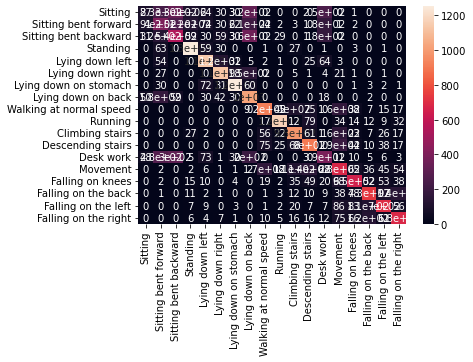

In [140]:
# Running cross-val for promising cnn thingy
params = {'filters':64, 'kernel_size':2, 'lr':0.001}
y_t, y_p = run_cross_val(final_sliding_windows_thingy, promising_cnn, params, epochs=10, n=48, batch_size=64)

## Tuning

In [52]:
# Tuning try_lstm
kernels= [2,3]
filters = [32,64,128]
dropouts = [0.0, 0.1, 0.3, 0.5]
lstm_units = [16,32,64,128,256]
nn_units = [32,64,128,256]
batch_sizes = [64, 128]
cnn_epochs = 20
learning_rates = [0.01,0.001]
lstm_epochs = 10
multihead_kernels = [[2, 3, 5],
                     [2, 5, 7],
                     [3, 5, 7],
                     [3, 5, 11],]

In [53]:
comparison_save_dir = 'models/comparisons/'

if not os.path.isdir(comparison_save_dir):
    os.mkdirs(comparison_save_dir)

### Functions and prep data

In [54]:
def get_cv_data(final_sliding_windows, n=3):
    loocv, X, y, groups = get_loocv(final_sliding_windows, n=n)

    y_pred_labels = np.empty(shape=(0,))
    y_true_labels = np.empty(shape=(0,))
    
    #trained_models = [] # For epoch experiments
    X_trains = []
    y_trains = []
    X_tests = []
    y_tests = []

    # this gives a train/test split that leaves one subject out in each iteration
    for i, (train_index, test_index) in enumerate(loocv.split(X, y, groups)):
        print("Starting iteration " + str(i) + ' of ' + str(n))

        X_train_full, X_test_full = X.iloc[train_index], X.iloc[test_index]
        y_train_full, y_test_full = y.iloc[train_index], y.iloc[test_index]

        X_train, y_train, X_test, y_test = format_data(X_train_full, y_train_full, X_test_full, y_test_full)
        
        # Yes this is very inefficient space-wise but it is to save time! 
        X_trains.append(X_train)
        y_trains.append(y_train)
        X_tests.append(X_test)
        y_tests.append(y_test)
        
        #df, trained_models = loopparas
    
    return X_trains, y_trains, X_tests, y_tests

In [55]:
def run_model_on_split(X_train, y_train, X_test, y_test, model_setup, params={}, batch_size=64, epochs=10, verbose=0):
    model = model_setup(**params)
    trained = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=verbose)

    # stats
    y_pred_ohe = model.predict(X_test)
    y_pred_labels = np.argmax(y_pred_ohe, axis=1)
    y_true_labels = np.argmax(y_test, axis=1)
    
    full_acc = accuracy_score(y_true_labels, y_pred_labels)
    grouped_y_true_labels = group_y(y_true_labels)
    grouped_y_pred_labels = group_y(y_pred_labels)
    subset_acc = accuracy_score(grouped_y_true_labels, grouped_y_pred_labels)
    
    return full_acc, subset_acc

In [56]:
def epoch_testing(X_train, y_train, X_test, y_test, model_setup, params={}, epochs=10, batch_size=64, verbose=0):
    model = model_setup(**params)
    trained = model.fit(X_train, y_train, validation_data=(X_test,y_test), batch_size=batch_size, epochs=epochs, verbose=verbose)
    
    return trained

In [82]:
# Get the train and test splits for each cross val
X_trains, y_trains, X_tests, y_tests = get_cv_data(final_sliding_windows_thingy)

Starting iteration 0 of 3
Formatting data...
(16274, 25, 6)
(7776, 25, 6)
(16274, 18)
(7776, 18)
Data formatted.
Starting iteration 1 of 3
Formatting data...
(15915, 25, 6)
(8135, 25, 6)
(15915, 18)
(8135, 18)
Data formatted.
Starting iteration 2 of 3
Formatting data...
(15911, 25, 6)
(8139, 25, 6)
(15911, 18)
(8139, 18)
Data formatted.


### Tune Epochs and Dropout rate

Make sure that the model setup function has defaults specified for everything!

In [27]:
# EPOCHS EXPERIMENT FOR TRY_LSTM

model_setup = try_lstm
epochs = lstm_epochs
n=3 # Must be same as used in get_cv_data!
save_file = 'try_lstm_epochs_dropouts_respeck.txt'
res = []

columns = ['title', 'data'] + ['loss' + str(j) for j in range(epochs)] + ['val_loss' + str(j) for j in range(epochs)]
columns += ['acc' + str(j) for j in range(epochs)] + ['val_acc' + str(j) for j in range(epochs)]

for dropout in dropouts:
    params = {'dropout':dropout} # Otherwise run with default parameters
    print(params)
    for i in range(n):
        print('\tData split ' + str(i) + ' @ ' + datetime.now().strftime("%H:%M:%S"))
        try:
            trained_model = epoch_testing(X_trains[i], y_trains[i], X_tests[i], y_tests[i], model_setup, verbose=0, params=params, epochs=epochs)
            
            r = []
            r += [str(params)]
            r += [i]
            r += trained_model.history['loss']
            r += trained_model.history['val_loss']
            r += trained_model.history['acc']
            r += trained_model.history['val_acc']
            
            res += [r]
        except Exception as ex:
            print('\tException: ' +  str(ex))
            
df = pd.DataFrame(res, columns=columns)
df.to_csv(comparison_save_dir + save_file)
    

{'dropout': 0.0}
	Data split 0 @ 16:27:10
	Data split 1 @ 16:30:36


KeyboardInterrupt: 

In [83]:
# EPOCHS EXPERIMENT FOR MULTIHEAD CNN

model_setup = multi_head_cnn
epochs = cnn_epochs
n=3 # Must be same as used in get_cv_data!
save_file = 'multihead_cnn_epochs_dropouts_thingy.txt'
res = []

columns = ['title', 'data'] + ['loss' + str(j) for j in range(epochs)] + ['val_loss' + str(j) for j in range(epochs)]
columns += ['acc' + str(j) for j in range(epochs)] + ['val_acc' + str(j) for j in range(epochs)]

for dropout in dropouts:
    for i in range(n):
        params = {'trainX': X_trains[i], 'trainy': y_trains[i], 'testX': X_tests[i], 'testy': y_tests[i], 'dropout':dropout} # Otherwise run with default parameters
#         print(params)
        print('\tData split ' + str(i) + ' @ ' + datetime.now().strftime("%H:%M:%S"))
        try:
            trained_model = epoch_testing([X_trains[i], X_trains[i], X_trains[i]],
                                          y_trains[i], 
                                          [X_tests[i], X_tests[i], X_tests[i]], 
                                          y_tests[i], 
                                          model_setup, 
                                          verbose=0, 
                                          params=params, 
                                          epochs=epochs)
            
            r = []
            # because most of the params are the input dataset this adds way too much to the save file
#             r += [str(params)]
            r+= [str({'dropout':dropout})]
            r += [i]
            r += trained_model.history['loss']
            r += trained_model.history['val_loss']
            r += trained_model.history['accuracy']
            r += trained_model.history['val_accuracy']
            
            res += [r]
        except Exception as ex:
            print('\tException: ' +  str(ex))
            
df = pd.DataFrame(res, columns=columns)
df.to_csv(comparison_save_dir + save_file)
    

	Data split 0 @ 20:58:06
Model: "model_25"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_76 (InputLayer)           [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_77 (InputLayer)           [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_78 (InputLayer)           [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_117 (Conv1D)             (None, 23, 64)       1216        input_76[0][0]                   
__________________________________________________________________

	Data split 2 @ 21:01:50
Model: "model_27"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_82 (InputLayer)           [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_83 (InputLayer)           [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_84 (InputLayer)           [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_123 (Conv1D)             (None, 23, 64)       1216        input_82[0][0]                   
__________________________________________________________________

	Data split 1 @ 21:05:38
Model: "model_29"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_88 (InputLayer)           [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_89 (InputLayer)           [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_90 (InputLayer)           [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_129 (Conv1D)             (None, 23, 64)       1216        input_88[0][0]                   
__________________________________________________________________

	Data split 0 @ 21:09:35
Model: "model_31"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_94 (InputLayer)           [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_95 (InputLayer)           [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_96 (InputLayer)           [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_135 (Conv1D)             (None, 23, 64)       1216        input_94[0][0]                   
__________________________________________________________________

	Data split 2 @ 21:13:44
Model: "model_33"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_100 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_101 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_102 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_141 (Conv1D)             (None, 23, 64)       1216        input_100[0][0]                  
__________________________________________________________________

	Data split 1 @ 21:17:52
Model: "model_35"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_106 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_107 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_108 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_147 (Conv1D)             (None, 23, 64)       1216        input_106[0][0]                  
__________________________________________________________________

In [35]:
# EPOCHS EXPERIMENT FOR PROMISING_CNN

for sensor in ['Respeck', 'Thingy']:
    # Get the train and test splits for each cross val
    if sensor == 'Respeck':
        X_trains, y_trains, X_tests, y_tests = get_cv_data(final_sliding_windows_respeck)
    else:
        X_trains, y_trains, X_tests, y_tests = get_cv_data(final_sliding_windows_thingy)

    model_setup = promising_cnn
    epochs = cnn_epochs
    n=3 # Must be same as used in get_cv_data!
    save_file = 'promising_cnn_epochs_' + sensor + '.txt'
    res = []

    columns = ['title', 'data'] + ['loss' + str(j) for j in range(epochs)] + ['val_loss' + str(j) for j in range(epochs)]
    columns += ['acc' + str(j) for j in range(epochs)] + ['val_acc' + str(j) for j in range(epochs)]
    
    params = {} # Otherwise run with default parameters
    print(params)            
    for i in range(n):
        print('\tData split ' + str(i) + ' @ ' + datetime.now().strftime("%H:%M:%S"))
        try:
            trained_model = epoch_testing(X_trains[i], y_trains[i], X_tests[i], y_tests[i], model_setup, verbose=0, params=params, epochs=epochs)
            
            r = []
            r += [str(params)]
            r += [i]
            r += trained_model.history['loss']
            r += trained_model.history['val_loss']
            r += trained_model.history['accuracy']
            r += trained_model.history['val_accuracy']
            
            res += [r]
        except Exception as ex:
            print('\tException: ' +  str(ex))

    df = pd.DataFrame(res, columns=columns)
    df.to_csv(comparison_save_dir + save_file)

Starting iteration 0 of 3
Formatting data...
(15947, 25, 6)
(8332, 25, 6)
(15947, 18)
(8332, 18)
Data formatted.
Starting iteration 1 of 3
Formatting data...
(15878, 25, 6)
(8401, 25, 6)
(15878, 18)
(8401, 18)
Data formatted.
Starting iteration 2 of 3
Formatting data...
(16733, 25, 6)
(7546, 25, 6)
(16733, 18)
(7546, 18)
Data formatted.
{}
	Data split 0 @ 17:42:40
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_24 (Conv1D)           (None, 23, 64)            1216      
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 11, 64)            0         
_________________________________________________________________
batch_normalization_24 (Batc (None, 11, 64)            256       
_________________________________________________________________
activation_24 (Activation)   (None, 11, 64)            0         
_________________

	Data split 1 @ 17:49:15
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_36 (Conv1D)           (None, 23, 64)            1216      
_________________________________________________________________
max_pooling1d_24 (MaxPooling (None, 11, 64)            0         
_________________________________________________________________
batch_normalization_36 (Batc (None, 11, 64)            256       
_________________________________________________________________
activation_36 (Activation)   (None, 11, 64)            0         
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 9, 64)             12352     
_________________________________________________________________
max_pooling1d_25 (MaxPooling (None, 4, 64)             0         
_________________________________________________________________
batch_normalization_37 (Batc

In [63]:
# EPOCHS EXPERIMENT FOR WAN_CNN

for sensor in ['Respeck', 'Thingy']:
    # Get the train and test splits for each cross val
    if sensor == 'Respeck':
        X_trains, y_trains, X_tests, y_tests = get_cv_data(final_sliding_windows_respeck)
    else:
        X_trains, y_trains, X_tests, y_tests = get_cv_data(final_sliding_windows_thingy)

    model_setup = wan_cnn
    epochs = cnn_epochs
    n=3 # Must be same as used in get_cv_data!
    save_file = 'wan_cnn_nostrides_epochs_' + sensor + '.txt'
    res = []

    columns = ['title', 'data'] + ['loss' + str(j) for j in range(epochs)] + ['val_loss' + str(j) for j in range(epochs)]
    columns += ['acc' + str(j) for j in range(epochs)] + ['val_acc' + str(j) for j in range(epochs)]
    
    params = {} # Otherwise run with default parameters
    print(params)            
    for i in range(n):
        print('\tData split ' + str(i) + ' @ ' + datetime.now().strftime("%H:%M:%S"))
        try:
            trained_model = epoch_testing(X_trains[i], y_trains[i], X_tests[i], y_tests[i], model_setup, verbose=0, params=params, epochs=epochs)
            
            r = []
            r += [str(params)]
            r += [i]
            r += trained_model.history['loss']
            r += trained_model.history['val_loss']
            r += trained_model.history['accuracy']
            r += trained_model.history['val_accuracy']
            
            res += [r]
        except Exception as ex:
            print('\tException: ' +  str(ex))

    df = pd.DataFrame(res, columns=columns)
    df.to_csv(comparison_save_dir + save_file)

Starting iteration 0 of 3
Formatting data...
(15947, 25, 6)
(8332, 25, 6)
(15947, 18)
(8332, 18)
Data formatted.
Starting iteration 1 of 3
Formatting data...
(15878, 25, 6)
(8401, 25, 6)
(15878, 18)
(8401, 18)
Data formatted.
Starting iteration 2 of 3
Formatting data...
(16733, 25, 6)
(7546, 25, 6)
(16733, 18)
(7546, 18)
Data formatted.
{}
	Data split 0 @ 23:02:50
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_51 (Conv1D)           (None, 19, 64)            2752      
_________________________________________________________________
max_pooling1d_50 (MaxPooling (None, 9, 64)             0         
_________________________________________________________________
dropout_45 (Dropout)         (None, 9, 64)             0         
_________________________________________________________________
conv1d_52 (Conv1D)           (None, 7, 64)             12352     
________________

	Data split 1 @ 23:15:00
Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_63 (Conv1D)           (None, 19, 64)            2752      
_________________________________________________________________
max_pooling1d_62 (MaxPooling (None, 9, 64)             0         
_________________________________________________________________
dropout_57 (Dropout)         (None, 9, 64)             0         
_________________________________________________________________
conv1d_64 (Conv1D)           (None, 7, 64)             12352     
_________________________________________________________________
max_pooling1d_63 (MaxPooling (None, 3, 64)             0         
_________________________________________________________________
dropout_58 (Dropout)         (None, 3, 64)             0         
_________________________________________________________________
conv1d_65 (Conv1D)          

### Plot epoch results from file

Number of plots you should see (otherwise change rows & cols in subplots): 1


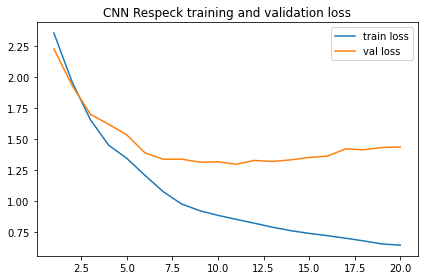

In [160]:
# uncomment to plot multihead cnn
epochs = 20
columns = ['title', 'data'] + ['loss' + str(j) for j in range(epochs)] + ['val_loss' + str(j) for j in range(epochs)]
columns += ['acc' + str(j) for j in range(epochs)] + ['val_acc' + str(j) for j in range(epochs)]

# # epoch_file = 'multihead_cnn_epochs_dropouts_thingy.txt'
epoch_file = 'promising_cnn_epochs_Respeck.txt'
# epoch_file = 'wan_cnn_nostrides_epochs_Respeck.txt'
df = pd.read_csv(comparison_save_dir + epoch_file)

def acc_plot(to_plot, ax):
    acc_cols = [c for c in columns if c[:4] == 'loss']
    val_acc_cols = [c for c in columns if c[:8] == 'val_loss']
    epochs = np.arange(len(acc_cols)) + 1

    ax.plot(epochs, df[acc_cols].mean(), label='train loss')
    ax.plot(epochs, df[val_acc_cols].mean(), label='val loss')
    ax.legend()

print('Number of plots you should see (otherwise change rows & cols in subplots): {}'.format(len(df['title'].unique())))
    
if len(df['title'].unique()) == 1:
    acc_plot(df, plt)
       
else:
    # You need to set the no. of rows and cols manually
    fig, axs = plt.subplots(2,2, figsize=(10,7)) 

    axs = axs.flatten()

    for i, title in enumerate(df['title'].unique()):
        axs[i].set_title(title)
        to_plot = df[df['title']==title]
        acc_plot(to_plot, axs[i])


plt.title('CNN Respeck training and validation loss')
plt.tight_layout()
plt.show()

# acc_cols = [c for c in columns if c[:3] == 'acc']
# val_acc_cols = [c for c in columns if c[:7] == 'val_acc']
# df[val_acc_cols].mean()

### Tune model parameters

Make sure to run get_cv_data first

In [99]:
# MODEL PARAMETER EXPERIMENT FOR TRY_LSTM

n=3 # Cross-val n used in get_cv_data
model_setup = try_lstm # Change this

# Set these from epoch experiment (Change this)
epochs = 2
dropout = 0.5
save_file = 'try_lstm_parameter_search.csv' # Change this

# Create list for saving configurations and accuracies
results = []
columns = ['epochs', 'dropout', 'lstm_unit', 'nn_units', 'batch_size', 'learning_rate'] # Change this
columns += ['acc_mean', 'sacc_mean'] # Same for all

# LSTM
# Change loops
for lstm_unit in lstm_units:
    for nn_unit in nn_units:
        for batch_size in batch_sizes:
            for learning_rate in learning_rates:
                # Change this
                params = {'dropout': dropout, 'lstm_units':lstm_unit, 'nn_units':nn_unit, 'learning_rate':learning_rate} # Params to model_setup. Batch size and learnign rate in line below
                print('\n' + str(params) + ', batch size: ' + str(batch_size))
                accs = []
                saccs = []
                for i in range(n):
                    print('\tIteration ' + str(i) + ' @ ' + datetime.now().strftime("%H:%M:%S"))
                    try:
                        acc, sacc = run_model_on_split(X_trains[i], y_trains[i], X_tests[i], y_tests[i], model_setup, params=params, batch_size=batch_size, epochs=epochs)
                        accs.append(acc)
                        saccs.append(sacc)
                        
                    except Exception as ex:
                        print('\tException: ' +  str(ex))
                    
                # Change this - must match columns!
                results.append([epochs, dropout, lstm_unit, nn_unit, batch_size, learning_rate, np.mean(accs), np.mean(saccs)])

# Save results to file
print('Saving to ' + comparison_save_dir + save_file)
df = pd.DataFrame(results, columns=columns)
df.to_csv(comparison_save_dir + save_file)


{'dropout': 0.5, 'lstm_units': 16, 'nn_units': 32, 'learning_rate': 0.1}, batch size: 32
	Iteration 0 @ 14:52:54
	Iteration 1 @ 14:53:14


KeyboardInterrupt: 

In [105]:
# MODEL PARAMETER EXPERIMENT FOR PROMISING CNN

for sensor in ['Respeck', 'Thingy']:
    # Get the train and test splits for each cross val
    if sensor == 'Respeck':
        X_trains, y_trains, X_tests, y_tests = get_cv_data(final_sliding_windows_respeck)
    else:
        X_trains, y_trains, X_tests, y_tests = get_cv_data(final_sliding_windows_thingy)
        
    n=3 # Cross-val n used in get_cv_data
    model_setup = promising_cnn # Change this

    # Set these from epoch experiment (Change this)
    epochs = 10
    save_file = 'promising_cnn_parameter_search_' + sensor + '.csv' # Change this

    # Create list for saving configurations and accuracies
    results = []
    columns = ['epochs', 'filters', 'kernel_size', 'batch_size', 'learning_rate'] # Change this
    columns += ['acc_mean', 'sacc_mean'] # Same for all
    
    for f in filters:
        for kernel in kernels:
            for batch_size in batch_sizes:
                for learning_rate in learning_rates:
                    # Change this
                    params = {'filters': f, 'kernel_size':kernel, 'lr':learning_rate} # Params to model_setup. Batch size and learnign rate in line below
                    print('\n' + str(params) + ', batch size: ' + str(batch_size))
                    accs = []
                    saccs = []
                    for i in range(n):
                        print('\tIteration ' + str(i) + ' @ ' + datetime.now().strftime("%H:%M:%S"))
                        try:
                            acc, sacc = run_model_on_split(X_trains[i], y_trains[i], X_tests[i], y_tests[i], model_setup, params=params, batch_size=batch_size, epochs=epochs)
                            accs.append(acc)
                            saccs.append(sacc)

                        except Exception as ex:
                            print('\tException: ' +  str(ex))

                    # Change this - must match columns!
                    results.append([epochs, f, kernel, batch_size, learning_rate, np.mean(accs), np.mean(saccs)])

    # Save results to file
    print('Saving to ' + comparison_save_dir + save_file)
    df = pd.DataFrame(results, columns=columns)
    df.to_csv(comparison_save_dir + save_file)

Starting iteration 0 of 3
Formatting data...
(15947, 25, 6)
(8332, 25, 6)
(15947, 18)
(8332, 18)
Data formatted.
Starting iteration 1 of 3
Formatting data...
(15878, 25, 6)
(8401, 25, 6)
(15878, 18)
(8401, 18)
Data formatted.
Starting iteration 2 of 3
Formatting data...
(16733, 25, 6)
(7546, 25, 6)
(16733, 18)
(7546, 18)
Data formatted.

{'filters': 16, 'kernel_size': 2, 'lr': 0.01}, batch size: 32
	Iteration 0 @ 23:35:44
Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_192 (Conv1D)          (None, 24, 16)            208       
_________________________________________________________________
max_pooling1d_165 (MaxPoolin (None, 12, 16)            0         
_________________________________________________________________
batch_normalization_81 (Batc (None, 12, 16)            64        
_________________________________________________________________
activation_81 (Activati

	Iteration 1 @ 23:41:18
Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_204 (Conv1D)          (None, 24, 16)            208       
_________________________________________________________________
max_pooling1d_173 (MaxPoolin (None, 12, 16)            0         
_________________________________________________________________
batch_normalization_93 (Batc (None, 12, 16)            64        
_________________________________________________________________
activation_93 (Activation)   (None, 12, 16)            0         
_________________________________________________________________
conv1d_205 (Conv1D)          (None, 11, 16)            528       
_________________________________________________________________
max_pooling1d_174 (MaxPoolin (None, 5, 16)             0         
_________________________________________________________________
batch_normalization_94 (Batc 

	Iteration 2 @ 23:44:52
Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_216 (Conv1D)          (None, 24, 16)            208       
_________________________________________________________________
max_pooling1d_181 (MaxPoolin (None, 12, 16)            0         
_________________________________________________________________
batch_normalization_105 (Bat (None, 12, 16)            64        
_________________________________________________________________
activation_105 (Activation)  (None, 12, 16)            0         
_________________________________________________________________
conv1d_217 (Conv1D)          (None, 11, 16)            528       
_________________________________________________________________
max_pooling1d_182 (MaxPoolin (None, 5, 16)             0         
_________________________________________________________________
batch_normalization_106 (Bat 


{'filters': 16, 'kernel_size': 2, 'lr': 0.01}, batch size: 128
	Iteration 0 @ 23:48:03
Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_228 (Conv1D)          (None, 24, 16)            208       
_________________________________________________________________
max_pooling1d_189 (MaxPoolin (None, 12, 16)            0         
_________________________________________________________________
batch_normalization_117 (Bat (None, 12, 16)            64        
_________________________________________________________________
activation_117 (Activation)  (None, 12, 16)            0         
_________________________________________________________________
conv1d_229 (Conv1D)          (None, 11, 16)            528       
_________________________________________________________________
max_pooling1d_190 (MaxPoolin (None, 5, 16)             0         
_______________________________

	Iteration 1 @ 23:49:36
Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_240 (Conv1D)          (None, 24, 16)            208       
_________________________________________________________________
max_pooling1d_197 (MaxPoolin (None, 12, 16)            0         
_________________________________________________________________
batch_normalization_129 (Bat (None, 12, 16)            64        
_________________________________________________________________
activation_129 (Activation)  (None, 12, 16)            0         
_________________________________________________________________
conv1d_241 (Conv1D)          (None, 11, 16)            528       
_________________________________________________________________
max_pooling1d_198 (MaxPoolin (None, 5, 16)             0         
_________________________________________________________________
batch_normalization_130 (Bat 

	Iteration 2 @ 23:50:52
Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_252 (Conv1D)          (None, 24, 16)            208       
_________________________________________________________________
max_pooling1d_205 (MaxPoolin (None, 12, 16)            0         
_________________________________________________________________
batch_normalization_141 (Bat (None, 12, 16)            64        
_________________________________________________________________
activation_141 (Activation)  (None, 12, 16)            0         
_________________________________________________________________
conv1d_253 (Conv1D)          (None, 11, 16)            528       
_________________________________________________________________
max_pooling1d_206 (MaxPoolin (None, 5, 16)             0         
_________________________________________________________________
batch_normalization_142 (Bat 


{'filters': 16, 'kernel_size': 3, 'lr': 0.01}, batch size: 32
	Iteration 0 @ 23:51:58
Model: "sequential_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_264 (Conv1D)          (None, 23, 16)            304       
_________________________________________________________________
max_pooling1d_213 (MaxPoolin (None, 11, 16)            0         
_________________________________________________________________
batch_normalization_153 (Bat (None, 11, 16)            64        
_________________________________________________________________
activation_153 (Activation)  (None, 11, 16)            0         
_________________________________________________________________
conv1d_265 (Conv1D)          (None, 9, 16)             784       
_________________________________________________________________
max_pooling1d_214 (MaxPoolin (None, 4, 16)             0         
________________________________

	Iteration 1 @ 23:57:49
Model: "sequential_55"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_276 (Conv1D)          (None, 23, 16)            304       
_________________________________________________________________
max_pooling1d_221 (MaxPoolin (None, 11, 16)            0         
_________________________________________________________________
batch_normalization_165 (Bat (None, 11, 16)            64        
_________________________________________________________________
activation_165 (Activation)  (None, 11, 16)            0         
_________________________________________________________________
conv1d_277 (Conv1D)          (None, 9, 16)             784       
_________________________________________________________________
max_pooling1d_222 (MaxPoolin (None, 4, 16)             0         
_________________________________________________________________
batch_normalization_166 (Bat 

	Iteration 2 @ 00:02:43
Model: "sequential_59"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_288 (Conv1D)          (None, 23, 16)            304       
_________________________________________________________________
max_pooling1d_229 (MaxPoolin (None, 11, 16)            0         
_________________________________________________________________
batch_normalization_177 (Bat (None, 11, 16)            64        
_________________________________________________________________
activation_177 (Activation)  (None, 11, 16)            0         
_________________________________________________________________
conv1d_289 (Conv1D)          (None, 9, 16)             784       
_________________________________________________________________
max_pooling1d_230 (MaxPoolin (None, 4, 16)             0         
_________________________________________________________________
batch_normalization_178 (Bat 


{'filters': 16, 'kernel_size': 3, 'lr': 0.01}, batch size: 128
	Iteration 0 @ 00:06:43
Model: "sequential_63"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_300 (Conv1D)          (None, 23, 16)            304       
_________________________________________________________________
max_pooling1d_237 (MaxPoolin (None, 11, 16)            0         
_________________________________________________________________
batch_normalization_189 (Bat (None, 11, 16)            64        
_________________________________________________________________
activation_189 (Activation)  (None, 11, 16)            0         
_________________________________________________________________
conv1d_301 (Conv1D)          (None, 9, 16)             784       
_________________________________________________________________
max_pooling1d_238 (MaxPoolin (None, 4, 16)             0         
_______________________________

	Iteration 1 @ 00:09:13
Model: "sequential_67"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_312 (Conv1D)          (None, 23, 16)            304       
_________________________________________________________________
max_pooling1d_245 (MaxPoolin (None, 11, 16)            0         
_________________________________________________________________
batch_normalization_201 (Bat (None, 11, 16)            64        
_________________________________________________________________
activation_201 (Activation)  (None, 11, 16)            0         
_________________________________________________________________
conv1d_313 (Conv1D)          (None, 9, 16)             784       
_________________________________________________________________
max_pooling1d_246 (MaxPoolin (None, 4, 16)             0         
_________________________________________________________________
batch_normalization_202 (Bat 

	Iteration 2 @ 00:10:44
Model: "sequential_71"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_324 (Conv1D)          (None, 23, 16)            304       
_________________________________________________________________
max_pooling1d_253 (MaxPoolin (None, 11, 16)            0         
_________________________________________________________________
batch_normalization_213 (Bat (None, 11, 16)            64        
_________________________________________________________________
activation_213 (Activation)  (None, 11, 16)            0         
_________________________________________________________________
conv1d_325 (Conv1D)          (None, 9, 16)             784       
_________________________________________________________________
max_pooling1d_254 (MaxPoolin (None, 4, 16)             0         
_________________________________________________________________
batch_normalization_214 (Bat 


{'filters': 32, 'kernel_size': 2, 'lr': 0.01}, batch size: 32
	Iteration 0 @ 00:11:45
Model: "sequential_75"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_336 (Conv1D)          (None, 24, 32)            416       
_________________________________________________________________
max_pooling1d_261 (MaxPoolin (None, 12, 32)            0         
_________________________________________________________________
batch_normalization_225 (Bat (None, 12, 32)            128       
_________________________________________________________________
activation_225 (Activation)  (None, 12, 32)            0         
_________________________________________________________________
conv1d_337 (Conv1D)          (None, 11, 32)            2080      
_________________________________________________________________
max_pooling1d_262 (MaxPoolin (None, 5, 32)             0         
________________________________

	Iteration 1 @ 00:15:45
Model: "sequential_79"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_348 (Conv1D)          (None, 24, 32)            416       
_________________________________________________________________
max_pooling1d_269 (MaxPoolin (None, 12, 32)            0         
_________________________________________________________________
batch_normalization_237 (Bat (None, 12, 32)            128       
_________________________________________________________________
activation_237 (Activation)  (None, 12, 32)            0         
_________________________________________________________________
conv1d_349 (Conv1D)          (None, 11, 32)            2080      
_________________________________________________________________
max_pooling1d_270 (MaxPoolin (None, 5, 32)             0         
_________________________________________________________________
batch_normalization_238 (Bat 

	Iteration 2 @ 00:19:00
Model: "sequential_83"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_360 (Conv1D)          (None, 24, 32)            416       
_________________________________________________________________
max_pooling1d_277 (MaxPoolin (None, 12, 32)            0         
_________________________________________________________________
batch_normalization_249 (Bat (None, 12, 32)            128       
_________________________________________________________________
activation_249 (Activation)  (None, 12, 32)            0         
_________________________________________________________________
conv1d_361 (Conv1D)          (None, 11, 32)            2080      
_________________________________________________________________
max_pooling1d_278 (MaxPoolin (None, 5, 32)             0         
_________________________________________________________________
batch_normalization_250 (Bat 


{'filters': 32, 'kernel_size': 2, 'lr': 0.01}, batch size: 128
	Iteration 0 @ 00:21:13
Model: "sequential_87"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_372 (Conv1D)          (None, 24, 32)            416       
_________________________________________________________________
max_pooling1d_285 (MaxPoolin (None, 12, 32)            0         
_________________________________________________________________
batch_normalization_261 (Bat (None, 12, 32)            128       
_________________________________________________________________
activation_261 (Activation)  (None, 12, 32)            0         
_________________________________________________________________
conv1d_373 (Conv1D)          (None, 11, 32)            2080      
_________________________________________________________________
max_pooling1d_286 (MaxPoolin (None, 5, 32)             0         
_______________________________

	Iteration 1 @ 00:22:25
Model: "sequential_91"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_384 (Conv1D)          (None, 24, 32)            416       
_________________________________________________________________
max_pooling1d_293 (MaxPoolin (None, 12, 32)            0         
_________________________________________________________________
batch_normalization_273 (Bat (None, 12, 32)            128       
_________________________________________________________________
activation_273 (Activation)  (None, 12, 32)            0         
_________________________________________________________________
conv1d_385 (Conv1D)          (None, 11, 32)            2080      
_________________________________________________________________
max_pooling1d_294 (MaxPoolin (None, 5, 32)             0         
_________________________________________________________________
batch_normalization_274 (Bat 

	Iteration 2 @ 00:23:31
Model: "sequential_95"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_396 (Conv1D)          (None, 24, 32)            416       
_________________________________________________________________
max_pooling1d_301 (MaxPoolin (None, 12, 32)            0         
_________________________________________________________________
batch_normalization_285 (Bat (None, 12, 32)            128       
_________________________________________________________________
activation_285 (Activation)  (None, 12, 32)            0         
_________________________________________________________________
conv1d_397 (Conv1D)          (None, 11, 32)            2080      
_________________________________________________________________
max_pooling1d_302 (MaxPoolin (None, 5, 32)             0         
_________________________________________________________________
batch_normalization_286 (Bat 


{'filters': 32, 'kernel_size': 3, 'lr': 0.01}, batch size: 32
	Iteration 0 @ 00:24:39
Model: "sequential_99"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_408 (Conv1D)          (None, 23, 32)            608       
_________________________________________________________________
max_pooling1d_309 (MaxPoolin (None, 11, 32)            0         
_________________________________________________________________
batch_normalization_297 (Bat (None, 11, 32)            128       
_________________________________________________________________
activation_297 (Activation)  (None, 11, 32)            0         
_________________________________________________________________
conv1d_409 (Conv1D)          (None, 9, 32)             3104      
_________________________________________________________________
max_pooling1d_310 (MaxPoolin (None, 4, 32)             0         
________________________________

	Iteration 1 @ 00:28:35
Model: "sequential_103"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_420 (Conv1D)          (None, 23, 32)            608       
_________________________________________________________________
max_pooling1d_317 (MaxPoolin (None, 11, 32)            0         
_________________________________________________________________
batch_normalization_309 (Bat (None, 11, 32)            128       
_________________________________________________________________
activation_309 (Activation)  (None, 11, 32)            0         
_________________________________________________________________
conv1d_421 (Conv1D)          (None, 9, 32)             3104      
_________________________________________________________________
max_pooling1d_318 (MaxPoolin (None, 4, 32)             0         
_________________________________________________________________
batch_normalization_310 (Bat

	Iteration 2 @ 00:31:35
Model: "sequential_107"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_432 (Conv1D)          (None, 23, 32)            608       
_________________________________________________________________
max_pooling1d_325 (MaxPoolin (None, 11, 32)            0         
_________________________________________________________________
batch_normalization_321 (Bat (None, 11, 32)            128       
_________________________________________________________________
activation_321 (Activation)  (None, 11, 32)            0         
_________________________________________________________________
conv1d_433 (Conv1D)          (None, 9, 32)             3104      
_________________________________________________________________
max_pooling1d_326 (MaxPoolin (None, 4, 32)             0         
_________________________________________________________________
batch_normalization_322 (Bat


{'filters': 32, 'kernel_size': 3, 'lr': 0.01}, batch size: 128
	Iteration 0 @ 00:33:45
Model: "sequential_111"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_444 (Conv1D)          (None, 23, 32)            608       
_________________________________________________________________
max_pooling1d_333 (MaxPoolin (None, 11, 32)            0         
_________________________________________________________________
batch_normalization_333 (Bat (None, 11, 32)            128       
_________________________________________________________________
activation_333 (Activation)  (None, 11, 32)            0         
_________________________________________________________________
conv1d_445 (Conv1D)          (None, 9, 32)             3104      
_________________________________________________________________
max_pooling1d_334 (MaxPoolin (None, 4, 32)             0         
______________________________

	Iteration 1 @ 00:35:04
Model: "sequential_115"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_456 (Conv1D)          (None, 23, 32)            608       
_________________________________________________________________
max_pooling1d_341 (MaxPoolin (None, 11, 32)            0         
_________________________________________________________________
batch_normalization_345 (Bat (None, 11, 32)            128       
_________________________________________________________________
activation_345 (Activation)  (None, 11, 32)            0         
_________________________________________________________________
conv1d_457 (Conv1D)          (None, 9, 32)             3104      
_________________________________________________________________
max_pooling1d_342 (MaxPoolin (None, 4, 32)             0         
_________________________________________________________________
batch_normalization_346 (Bat

	Iteration 2 @ 00:36:13
Model: "sequential_119"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_468 (Conv1D)          (None, 23, 32)            608       
_________________________________________________________________
max_pooling1d_349 (MaxPoolin (None, 11, 32)            0         
_________________________________________________________________
batch_normalization_357 (Bat (None, 11, 32)            128       
_________________________________________________________________
activation_357 (Activation)  (None, 11, 32)            0         
_________________________________________________________________
conv1d_469 (Conv1D)          (None, 9, 32)             3104      
_________________________________________________________________
max_pooling1d_350 (MaxPoolin (None, 4, 32)             0         
_________________________________________________________________
batch_normalization_358 (Bat


{'filters': 64, 'kernel_size': 2, 'lr': 0.01}, batch size: 32
	Iteration 0 @ 00:37:13
Model: "sequential_123"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_480 (Conv1D)          (None, 24, 64)            832       
_________________________________________________________________
max_pooling1d_357 (MaxPoolin (None, 12, 64)            0         
_________________________________________________________________
batch_normalization_369 (Bat (None, 12, 64)            256       
_________________________________________________________________
activation_369 (Activation)  (None, 12, 64)            0         
_________________________________________________________________
conv1d_481 (Conv1D)          (None, 11, 64)            8256      
_________________________________________________________________
max_pooling1d_358 (MaxPoolin (None, 5, 64)             0         
_______________________________

	Iteration 1 @ 00:40:44
Model: "sequential_127"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_492 (Conv1D)          (None, 24, 64)            832       
_________________________________________________________________
max_pooling1d_365 (MaxPoolin (None, 12, 64)            0         
_________________________________________________________________
batch_normalization_381 (Bat (None, 12, 64)            256       
_________________________________________________________________
activation_381 (Activation)  (None, 12, 64)            0         
_________________________________________________________________
conv1d_493 (Conv1D)          (None, 11, 64)            8256      
_________________________________________________________________
max_pooling1d_366 (MaxPoolin (None, 5, 64)             0         
_________________________________________________________________
batch_normalization_382 (Bat

	Iteration 2 @ 00:43:33
Model: "sequential_131"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_504 (Conv1D)          (None, 24, 64)            832       
_________________________________________________________________
max_pooling1d_373 (MaxPoolin (None, 12, 64)            0         
_________________________________________________________________
batch_normalization_393 (Bat (None, 12, 64)            256       
_________________________________________________________________
activation_393 (Activation)  (None, 12, 64)            0         
_________________________________________________________________
conv1d_505 (Conv1D)          (None, 11, 64)            8256      
_________________________________________________________________
max_pooling1d_374 (MaxPoolin (None, 5, 64)             0         
_________________________________________________________________
batch_normalization_394 (Bat


{'filters': 64, 'kernel_size': 2, 'lr': 0.01}, batch size: 128
	Iteration 0 @ 00:45:46
Model: "sequential_135"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_516 (Conv1D)          (None, 24, 64)            832       
_________________________________________________________________
max_pooling1d_381 (MaxPoolin (None, 12, 64)            0         
_________________________________________________________________
batch_normalization_405 (Bat (None, 12, 64)            256       
_________________________________________________________________
activation_405 (Activation)  (None, 12, 64)            0         
_________________________________________________________________
conv1d_517 (Conv1D)          (None, 11, 64)            8256      
_________________________________________________________________
max_pooling1d_382 (MaxPoolin (None, 5, 64)             0         
______________________________

	Iteration 1 @ 00:47:24
Model: "sequential_139"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_528 (Conv1D)          (None, 24, 64)            832       
_________________________________________________________________
max_pooling1d_389 (MaxPoolin (None, 12, 64)            0         
_________________________________________________________________
batch_normalization_417 (Bat (None, 12, 64)            256       
_________________________________________________________________
activation_417 (Activation)  (None, 12, 64)            0         
_________________________________________________________________
conv1d_529 (Conv1D)          (None, 11, 64)            8256      
_________________________________________________________________
max_pooling1d_390 (MaxPoolin (None, 5, 64)             0         
_________________________________________________________________
batch_normalization_418 (Bat

	Iteration 2 @ 00:48:50
Model: "sequential_143"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_540 (Conv1D)          (None, 24, 64)            832       
_________________________________________________________________
max_pooling1d_397 (MaxPoolin (None, 12, 64)            0         
_________________________________________________________________
batch_normalization_429 (Bat (None, 12, 64)            256       
_________________________________________________________________
activation_429 (Activation)  (None, 12, 64)            0         
_________________________________________________________________
conv1d_541 (Conv1D)          (None, 11, 64)            8256      
_________________________________________________________________
max_pooling1d_398 (MaxPoolin (None, 5, 64)             0         
_________________________________________________________________
batch_normalization_430 (Bat


{'filters': 64, 'kernel_size': 3, 'lr': 0.01}, batch size: 32
	Iteration 0 @ 00:50:08
Model: "sequential_147"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_552 (Conv1D)          (None, 23, 64)            1216      
_________________________________________________________________
max_pooling1d_405 (MaxPoolin (None, 11, 64)            0         
_________________________________________________________________
batch_normalization_441 (Bat (None, 11, 64)            256       
_________________________________________________________________
activation_441 (Activation)  (None, 11, 64)            0         
_________________________________________________________________
conv1d_553 (Conv1D)          (None, 9, 64)             12352     
_________________________________________________________________
max_pooling1d_406 (MaxPoolin (None, 4, 64)             0         
_______________________________

	Iteration 1 @ 00:53:32
Model: "sequential_151"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_564 (Conv1D)          (None, 23, 64)            1216      
_________________________________________________________________
max_pooling1d_413 (MaxPoolin (None, 11, 64)            0         
_________________________________________________________________
batch_normalization_453 (Bat (None, 11, 64)            256       
_________________________________________________________________
activation_453 (Activation)  (None, 11, 64)            0         
_________________________________________________________________
conv1d_565 (Conv1D)          (None, 9, 64)             12352     
_________________________________________________________________
max_pooling1d_414 (MaxPoolin (None, 4, 64)             0         
_________________________________________________________________
batch_normalization_454 (Bat

	Iteration 2 @ 00:56:17
Model: "sequential_155"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_576 (Conv1D)          (None, 23, 64)            1216      
_________________________________________________________________
max_pooling1d_421 (MaxPoolin (None, 11, 64)            0         
_________________________________________________________________
batch_normalization_465 (Bat (None, 11, 64)            256       
_________________________________________________________________
activation_465 (Activation)  (None, 11, 64)            0         
_________________________________________________________________
conv1d_577 (Conv1D)          (None, 9, 64)             12352     
_________________________________________________________________
max_pooling1d_422 (MaxPoolin (None, 4, 64)             0         
_________________________________________________________________
batch_normalization_466 (Bat


{'filters': 64, 'kernel_size': 3, 'lr': 0.01}, batch size: 128
	Iteration 0 @ 00:58:22
Model: "sequential_159"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_588 (Conv1D)          (None, 23, 64)            1216      
_________________________________________________________________
max_pooling1d_429 (MaxPoolin (None, 11, 64)            0         
_________________________________________________________________
batch_normalization_477 (Bat (None, 11, 64)            256       
_________________________________________________________________
activation_477 (Activation)  (None, 11, 64)            0         
_________________________________________________________________
conv1d_589 (Conv1D)          (None, 9, 64)             12352     
_________________________________________________________________
max_pooling1d_430 (MaxPoolin (None, 4, 64)             0         
______________________________

	Iteration 1 @ 00:59:51
Model: "sequential_163"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_600 (Conv1D)          (None, 23, 64)            1216      
_________________________________________________________________
max_pooling1d_437 (MaxPoolin (None, 11, 64)            0         
_________________________________________________________________
batch_normalization_489 (Bat (None, 11, 64)            256       
_________________________________________________________________
activation_489 (Activation)  (None, 11, 64)            0         
_________________________________________________________________
conv1d_601 (Conv1D)          (None, 9, 64)             12352     
_________________________________________________________________
max_pooling1d_438 (MaxPoolin (None, 4, 64)             0         
_________________________________________________________________
batch_normalization_490 (Bat

	Iteration 2 @ 01:01:18
Model: "sequential_167"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_612 (Conv1D)          (None, 23, 64)            1216      
_________________________________________________________________
max_pooling1d_445 (MaxPoolin (None, 11, 64)            0         
_________________________________________________________________
batch_normalization_501 (Bat (None, 11, 64)            256       
_________________________________________________________________
activation_501 (Activation)  (None, 11, 64)            0         
_________________________________________________________________
conv1d_613 (Conv1D)          (None, 9, 64)             12352     
_________________________________________________________________
max_pooling1d_446 (MaxPoolin (None, 4, 64)             0         
_________________________________________________________________
batch_normalization_502 (Bat


{'filters': 128, 'kernel_size': 2, 'lr': 0.01}, batch size: 32
	Iteration 0 @ 01:02:28
Model: "sequential_171"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_624 (Conv1D)          (None, 24, 128)           1664      
_________________________________________________________________
max_pooling1d_453 (MaxPoolin (None, 12, 128)           0         
_________________________________________________________________
batch_normalization_513 (Bat (None, 12, 128)           512       
_________________________________________________________________
activation_513 (Activation)  (None, 12, 128)           0         
_________________________________________________________________
conv1d_625 (Conv1D)          (None, 11, 128)           32896     
_________________________________________________________________
max_pooling1d_454 (MaxPoolin (None, 5, 128)            0         
______________________________

	Iteration 1 @ 01:06:45
Model: "sequential_175"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_636 (Conv1D)          (None, 24, 128)           1664      
_________________________________________________________________
max_pooling1d_461 (MaxPoolin (None, 12, 128)           0         
_________________________________________________________________
batch_normalization_525 (Bat (None, 12, 128)           512       
_________________________________________________________________
activation_525 (Activation)  (None, 12, 128)           0         
_________________________________________________________________
conv1d_637 (Conv1D)          (None, 11, 128)           32896     
_________________________________________________________________
max_pooling1d_462 (MaxPoolin (None, 5, 128)            0         
_________________________________________________________________
batch_normalization_526 (Bat

	Iteration 2 @ 01:10:34
Model: "sequential_179"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_648 (Conv1D)          (None, 24, 128)           1664      
_________________________________________________________________
max_pooling1d_469 (MaxPoolin (None, 12, 128)           0         
_________________________________________________________________
batch_normalization_537 (Bat (None, 12, 128)           512       
_________________________________________________________________
activation_537 (Activation)  (None, 12, 128)           0         
_________________________________________________________________
conv1d_649 (Conv1D)          (None, 11, 128)           32896     
_________________________________________________________________
max_pooling1d_470 (MaxPoolin (None, 5, 128)            0         
_________________________________________________________________
batch_normalization_538 (Bat


{'filters': 128, 'kernel_size': 2, 'lr': 0.01}, batch size: 128
	Iteration 0 @ 01:13:43
Model: "sequential_183"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_660 (Conv1D)          (None, 24, 128)           1664      
_________________________________________________________________
max_pooling1d_477 (MaxPoolin (None, 12, 128)           0         
_________________________________________________________________
batch_normalization_549 (Bat (None, 12, 128)           512       
_________________________________________________________________
activation_549 (Activation)  (None, 12, 128)           0         
_________________________________________________________________
conv1d_661 (Conv1D)          (None, 11, 128)           32896     
_________________________________________________________________
max_pooling1d_478 (MaxPoolin (None, 5, 128)            0         
_____________________________

	Iteration 1 @ 01:16:23
Model: "sequential_187"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_672 (Conv1D)          (None, 24, 128)           1664      
_________________________________________________________________
max_pooling1d_485 (MaxPoolin (None, 12, 128)           0         
_________________________________________________________________
batch_normalization_561 (Bat (None, 12, 128)           512       
_________________________________________________________________
activation_561 (Activation)  (None, 12, 128)           0         
_________________________________________________________________
conv1d_673 (Conv1D)          (None, 11, 128)           32896     
_________________________________________________________________
max_pooling1d_486 (MaxPoolin (None, 5, 128)            0         
_________________________________________________________________
batch_normalization_562 (Bat

	Iteration 2 @ 01:18:43
Model: "sequential_191"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_684 (Conv1D)          (None, 24, 128)           1664      
_________________________________________________________________
max_pooling1d_493 (MaxPoolin (None, 12, 128)           0         
_________________________________________________________________
batch_normalization_573 (Bat (None, 12, 128)           512       
_________________________________________________________________
activation_573 (Activation)  (None, 12, 128)           0         
_________________________________________________________________
conv1d_685 (Conv1D)          (None, 11, 128)           32896     
_________________________________________________________________
max_pooling1d_494 (MaxPoolin (None, 5, 128)            0         
_________________________________________________________________
batch_normalization_574 (Bat


{'filters': 128, 'kernel_size': 3, 'lr': 0.01}, batch size: 32
	Iteration 0 @ 01:20:54
Model: "sequential_195"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_696 (Conv1D)          (None, 23, 128)           2432      
_________________________________________________________________
max_pooling1d_501 (MaxPoolin (None, 11, 128)           0         
_________________________________________________________________
batch_normalization_585 (Bat (None, 11, 128)           512       
_________________________________________________________________
activation_585 (Activation)  (None, 11, 128)           0         
_________________________________________________________________
conv1d_697 (Conv1D)          (None, 9, 128)            49280     
_________________________________________________________________
max_pooling1d_502 (MaxPoolin (None, 4, 128)            0         
______________________________

	Iteration 1 @ 01:25:08
Model: "sequential_199"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_708 (Conv1D)          (None, 23, 128)           2432      
_________________________________________________________________
max_pooling1d_509 (MaxPoolin (None, 11, 128)           0         
_________________________________________________________________
batch_normalization_597 (Bat (None, 11, 128)           512       
_________________________________________________________________
activation_597 (Activation)  (None, 11, 128)           0         
_________________________________________________________________
conv1d_709 (Conv1D)          (None, 9, 128)            49280     
_________________________________________________________________
max_pooling1d_510 (MaxPoolin (None, 4, 128)            0         
_________________________________________________________________
batch_normalization_598 (Bat

	Iteration 2 @ 01:28:48
Model: "sequential_203"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_720 (Conv1D)          (None, 23, 128)           2432      
_________________________________________________________________
max_pooling1d_517 (MaxPoolin (None, 11, 128)           0         
_________________________________________________________________
batch_normalization_609 (Bat (None, 11, 128)           512       
_________________________________________________________________
activation_609 (Activation)  (None, 11, 128)           0         
_________________________________________________________________
conv1d_721 (Conv1D)          (None, 9, 128)            49280     
_________________________________________________________________
max_pooling1d_518 (MaxPoolin (None, 4, 128)            0         
_________________________________________________________________
batch_normalization_610 (Bat


{'filters': 128, 'kernel_size': 3, 'lr': 0.01}, batch size: 128
	Iteration 0 @ 01:31:52
Model: "sequential_207"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_732 (Conv1D)          (None, 23, 128)           2432      
_________________________________________________________________
max_pooling1d_525 (MaxPoolin (None, 11, 128)           0         
_________________________________________________________________
batch_normalization_621 (Bat (None, 11, 128)           512       
_________________________________________________________________
activation_621 (Activation)  (None, 11, 128)           0         
_________________________________________________________________
conv1d_733 (Conv1D)          (None, 9, 128)            49280     
_________________________________________________________________
max_pooling1d_526 (MaxPoolin (None, 4, 128)            0         
_____________________________

	Iteration 1 @ 01:34:11
Model: "sequential_211"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_744 (Conv1D)          (None, 23, 128)           2432      
_________________________________________________________________
max_pooling1d_533 (MaxPoolin (None, 11, 128)           0         
_________________________________________________________________
batch_normalization_633 (Bat (None, 11, 128)           512       
_________________________________________________________________
activation_633 (Activation)  (None, 11, 128)           0         
_________________________________________________________________
conv1d_745 (Conv1D)          (None, 9, 128)            49280     
_________________________________________________________________
max_pooling1d_534 (MaxPoolin (None, 4, 128)            0         
_________________________________________________________________
batch_normalization_634 (Bat

	Iteration 2 @ 01:36:22
Model: "sequential_215"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_756 (Conv1D)          (None, 23, 128)           2432      
_________________________________________________________________
max_pooling1d_541 (MaxPoolin (None, 11, 128)           0         
_________________________________________________________________
batch_normalization_645 (Bat (None, 11, 128)           512       
_________________________________________________________________
activation_645 (Activation)  (None, 11, 128)           0         
_________________________________________________________________
conv1d_757 (Conv1D)          (None, 9, 128)            49280     
_________________________________________________________________
max_pooling1d_542 (MaxPoolin (None, 4, 128)            0         
_________________________________________________________________
batch_normalization_646 (Bat

Saving to models/comparisons/promising_cnn_parameter_search_Respeck.csv
Starting iteration 0 of 3
Formatting data...
(16274, 25, 6)
(7776, 25, 6)
(16274, 18)
(7776, 18)
Data formatted.
Starting iteration 1 of 3
Formatting data...
(15915, 25, 6)
(8135, 25, 6)
(15915, 18)
(8135, 18)
Data formatted.
Starting iteration 2 of 3
Formatting data...
(15911, 25, 6)
(8139, 25, 6)
(15911, 18)
(8139, 18)
Data formatted.

{'filters': 16, 'kernel_size': 2, 'lr': 0.01}, batch size: 32
	Iteration 0 @ 01:39:43
Model: "sequential_219"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_768 (Conv1D)          (None, 24, 16)            208       
_________________________________________________________________
max_pooling1d_549 (MaxPoolin (None, 12, 16)            0         
_________________________________________________________________
batch_normalization_657 (Bat (None, 12, 16)            64        
________________

	Iteration 1 @ 01:45:15
Model: "sequential_223"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_780 (Conv1D)          (None, 24, 16)            208       
_________________________________________________________________
max_pooling1d_557 (MaxPoolin (None, 12, 16)            0         
_________________________________________________________________
batch_normalization_669 (Bat (None, 12, 16)            64        
_________________________________________________________________
activation_669 (Activation)  (None, 12, 16)            0         
_________________________________________________________________
conv1d_781 (Conv1D)          (None, 11, 16)            528       
_________________________________________________________________
max_pooling1d_558 (MaxPoolin (None, 5, 16)             0         
_________________________________________________________________
batch_normalization_670 (Bat

	Iteration 2 @ 01:49:17
Model: "sequential_227"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_792 (Conv1D)          (None, 24, 16)            208       
_________________________________________________________________
max_pooling1d_565 (MaxPoolin (None, 12, 16)            0         
_________________________________________________________________
batch_normalization_681 (Bat (None, 12, 16)            64        
_________________________________________________________________
activation_681 (Activation)  (None, 12, 16)            0         
_________________________________________________________________
conv1d_793 (Conv1D)          (None, 11, 16)            528       
_________________________________________________________________
max_pooling1d_566 (MaxPoolin (None, 5, 16)             0         
_________________________________________________________________
batch_normalization_682 (Bat


{'filters': 16, 'kernel_size': 2, 'lr': 0.01}, batch size: 128
	Iteration 0 @ 01:52:07
Model: "sequential_231"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_804 (Conv1D)          (None, 24, 16)            208       
_________________________________________________________________
max_pooling1d_573 (MaxPoolin (None, 12, 16)            0         
_________________________________________________________________
batch_normalization_693 (Bat (None, 12, 16)            64        
_________________________________________________________________
activation_693 (Activation)  (None, 12, 16)            0         
_________________________________________________________________
conv1d_805 (Conv1D)          (None, 11, 16)            528       
_________________________________________________________________
max_pooling1d_574 (MaxPoolin (None, 5, 16)             0         
______________________________

	Iteration 1 @ 01:54:04
Model: "sequential_235"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_816 (Conv1D)          (None, 24, 16)            208       
_________________________________________________________________
max_pooling1d_581 (MaxPoolin (None, 12, 16)            0         
_________________________________________________________________
batch_normalization_705 (Bat (None, 12, 16)            64        
_________________________________________________________________
activation_705 (Activation)  (None, 12, 16)            0         
_________________________________________________________________
conv1d_817 (Conv1D)          (None, 11, 16)            528       
_________________________________________________________________
max_pooling1d_582 (MaxPoolin (None, 5, 16)             0         
_________________________________________________________________
batch_normalization_706 (Bat

	Iteration 2 @ 01:55:34
Model: "sequential_239"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_828 (Conv1D)          (None, 24, 16)            208       
_________________________________________________________________
max_pooling1d_589 (MaxPoolin (None, 12, 16)            0         
_________________________________________________________________
batch_normalization_717 (Bat (None, 12, 16)            64        
_________________________________________________________________
activation_717 (Activation)  (None, 12, 16)            0         
_________________________________________________________________
conv1d_829 (Conv1D)          (None, 11, 16)            528       
_________________________________________________________________
max_pooling1d_590 (MaxPoolin (None, 5, 16)             0         
_________________________________________________________________
batch_normalization_718 (Bat


{'filters': 16, 'kernel_size': 3, 'lr': 0.01}, batch size: 32
	Iteration 0 @ 01:56:37
Model: "sequential_243"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_840 (Conv1D)          (None, 23, 16)            304       
_________________________________________________________________
max_pooling1d_597 (MaxPoolin (None, 11, 16)            0         
_________________________________________________________________
batch_normalization_729 (Bat (None, 11, 16)            64        
_________________________________________________________________
activation_729 (Activation)  (None, 11, 16)            0         
_________________________________________________________________
conv1d_841 (Conv1D)          (None, 9, 16)             784       
_________________________________________________________________
max_pooling1d_598 (MaxPoolin (None, 4, 16)             0         
_______________________________

	Iteration 1 @ 02:02:24
Model: "sequential_247"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_852 (Conv1D)          (None, 23, 16)            304       
_________________________________________________________________
max_pooling1d_605 (MaxPoolin (None, 11, 16)            0         
_________________________________________________________________
batch_normalization_741 (Bat (None, 11, 16)            64        
_________________________________________________________________
activation_741 (Activation)  (None, 11, 16)            0         
_________________________________________________________________
conv1d_853 (Conv1D)          (None, 9, 16)             784       
_________________________________________________________________
max_pooling1d_606 (MaxPoolin (None, 4, 16)             0         
_________________________________________________________________
batch_normalization_742 (Bat

	Iteration 2 @ 02:06:56
Model: "sequential_251"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_864 (Conv1D)          (None, 23, 16)            304       
_________________________________________________________________
max_pooling1d_613 (MaxPoolin (None, 11, 16)            0         
_________________________________________________________________
batch_normalization_753 (Bat (None, 11, 16)            64        
_________________________________________________________________
activation_753 (Activation)  (None, 11, 16)            0         
_________________________________________________________________
conv1d_865 (Conv1D)          (None, 9, 16)             784       
_________________________________________________________________
max_pooling1d_614 (MaxPoolin (None, 4, 16)             0         
_________________________________________________________________
batch_normalization_754 (Bat


{'filters': 16, 'kernel_size': 3, 'lr': 0.01}, batch size: 128
	Iteration 0 @ 02:09:58
Model: "sequential_255"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_876 (Conv1D)          (None, 23, 16)            304       
_________________________________________________________________
max_pooling1d_621 (MaxPoolin (None, 11, 16)            0         
_________________________________________________________________
batch_normalization_765 (Bat (None, 11, 16)            64        
_________________________________________________________________
activation_765 (Activation)  (None, 11, 16)            0         
_________________________________________________________________
conv1d_877 (Conv1D)          (None, 9, 16)             784       
_________________________________________________________________
max_pooling1d_622 (MaxPoolin (None, 4, 16)             0         
______________________________

	Iteration 1 @ 02:11:57
Model: "sequential_259"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_888 (Conv1D)          (None, 23, 16)            304       
_________________________________________________________________
max_pooling1d_629 (MaxPoolin (None, 11, 16)            0         
_________________________________________________________________
batch_normalization_777 (Bat (None, 11, 16)            64        
_________________________________________________________________
activation_777 (Activation)  (None, 11, 16)            0         
_________________________________________________________________
conv1d_889 (Conv1D)          (None, 9, 16)             784       
_________________________________________________________________
max_pooling1d_630 (MaxPoolin (None, 4, 16)             0         
_________________________________________________________________
batch_normalization_778 (Bat

	Iteration 2 @ 02:13:22
Model: "sequential_263"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_900 (Conv1D)          (None, 23, 16)            304       
_________________________________________________________________
max_pooling1d_637 (MaxPoolin (None, 11, 16)            0         
_________________________________________________________________
batch_normalization_789 (Bat (None, 11, 16)            64        
_________________________________________________________________
activation_789 (Activation)  (None, 11, 16)            0         
_________________________________________________________________
conv1d_901 (Conv1D)          (None, 9, 16)             784       
_________________________________________________________________
max_pooling1d_638 (MaxPoolin (None, 4, 16)             0         
_________________________________________________________________
batch_normalization_790 (Bat


{'filters': 32, 'kernel_size': 2, 'lr': 0.01}, batch size: 32
	Iteration 0 @ 02:14:37
Model: "sequential_267"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_912 (Conv1D)          (None, 24, 32)            416       
_________________________________________________________________
max_pooling1d_645 (MaxPoolin (None, 12, 32)            0         
_________________________________________________________________
batch_normalization_801 (Bat (None, 12, 32)            128       
_________________________________________________________________
activation_801 (Activation)  (None, 12, 32)            0         
_________________________________________________________________
conv1d_913 (Conv1D)          (None, 11, 32)            2080      
_________________________________________________________________
max_pooling1d_646 (MaxPoolin (None, 5, 32)             0         
_______________________________

	Iteration 1 @ 02:18:09
Model: "sequential_271"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_924 (Conv1D)          (None, 24, 32)            416       
_________________________________________________________________
max_pooling1d_653 (MaxPoolin (None, 12, 32)            0         
_________________________________________________________________
batch_normalization_813 (Bat (None, 12, 32)            128       
_________________________________________________________________
activation_813 (Activation)  (None, 12, 32)            0         
_________________________________________________________________
conv1d_925 (Conv1D)          (None, 11, 32)            2080      
_________________________________________________________________
max_pooling1d_654 (MaxPoolin (None, 5, 32)             0         
_________________________________________________________________
batch_normalization_814 (Bat

	Iteration 2 @ 02:21:13
Model: "sequential_275"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_936 (Conv1D)          (None, 24, 32)            416       
_________________________________________________________________
max_pooling1d_661 (MaxPoolin (None, 12, 32)            0         
_________________________________________________________________
batch_normalization_825 (Bat (None, 12, 32)            128       
_________________________________________________________________
activation_825 (Activation)  (None, 12, 32)            0         
_________________________________________________________________
conv1d_937 (Conv1D)          (None, 11, 32)            2080      
_________________________________________________________________
max_pooling1d_662 (MaxPoolin (None, 5, 32)             0         
_________________________________________________________________
batch_normalization_826 (Bat


{'filters': 32, 'kernel_size': 2, 'lr': 0.01}, batch size: 128
	Iteration 0 @ 02:23:25
Model: "sequential_279"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_948 (Conv1D)          (None, 24, 32)            416       
_________________________________________________________________
max_pooling1d_669 (MaxPoolin (None, 12, 32)            0         
_________________________________________________________________
batch_normalization_837 (Bat (None, 12, 32)            128       
_________________________________________________________________
activation_837 (Activation)  (None, 12, 32)            0         
_________________________________________________________________
conv1d_949 (Conv1D)          (None, 11, 32)            2080      
_________________________________________________________________
max_pooling1d_670 (MaxPoolin (None, 5, 32)             0         
______________________________

	Iteration 1 @ 02:24:53
Model: "sequential_283"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_960 (Conv1D)          (None, 24, 32)            416       
_________________________________________________________________
max_pooling1d_677 (MaxPoolin (None, 12, 32)            0         
_________________________________________________________________
batch_normalization_849 (Bat (None, 12, 32)            128       
_________________________________________________________________
activation_849 (Activation)  (None, 12, 32)            0         
_________________________________________________________________
conv1d_961 (Conv1D)          (None, 11, 32)            2080      
_________________________________________________________________
max_pooling1d_678 (MaxPoolin (None, 5, 32)             0         
_________________________________________________________________
batch_normalization_850 (Bat

	Iteration 2 @ 02:26:17
Model: "sequential_287"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_972 (Conv1D)          (None, 24, 32)            416       
_________________________________________________________________
max_pooling1d_685 (MaxPoolin (None, 12, 32)            0         
_________________________________________________________________
batch_normalization_861 (Bat (None, 12, 32)            128       
_________________________________________________________________
activation_861 (Activation)  (None, 12, 32)            0         
_________________________________________________________________
conv1d_973 (Conv1D)          (None, 11, 32)            2080      
_________________________________________________________________
max_pooling1d_686 (MaxPoolin (None, 5, 32)             0         
_________________________________________________________________
batch_normalization_862 (Bat


{'filters': 32, 'kernel_size': 3, 'lr': 0.01}, batch size: 32
	Iteration 0 @ 02:27:20
Model: "sequential_291"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_984 (Conv1D)          (None, 23, 32)            608       
_________________________________________________________________
max_pooling1d_693 (MaxPoolin (None, 11, 32)            0         
_________________________________________________________________
batch_normalization_873 (Bat (None, 11, 32)            128       
_________________________________________________________________
activation_873 (Activation)  (None, 11, 32)            0         
_________________________________________________________________
conv1d_985 (Conv1D)          (None, 9, 32)             3104      
_________________________________________________________________
max_pooling1d_694 (MaxPoolin (None, 4, 32)             0         
_______________________________

	Iteration 1 @ 02:31:05
Model: "sequential_295"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_996 (Conv1D)          (None, 23, 32)            608       
_________________________________________________________________
max_pooling1d_701 (MaxPoolin (None, 11, 32)            0         
_________________________________________________________________
batch_normalization_885 (Bat (None, 11, 32)            128       
_________________________________________________________________
activation_885 (Activation)  (None, 11, 32)            0         
_________________________________________________________________
conv1d_997 (Conv1D)          (None, 9, 32)             3104      
_________________________________________________________________
max_pooling1d_702 (MaxPoolin (None, 4, 32)             0         
_________________________________________________________________
batch_normalization_886 (Bat

	Iteration 2 @ 02:34:06
Model: "sequential_299"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1008 (Conv1D)         (None, 23, 32)            608       
_________________________________________________________________
max_pooling1d_709 (MaxPoolin (None, 11, 32)            0         
_________________________________________________________________
batch_normalization_897 (Bat (None, 11, 32)            128       
_________________________________________________________________
activation_897 (Activation)  (None, 11, 32)            0         
_________________________________________________________________
conv1d_1009 (Conv1D)         (None, 9, 32)             3104      
_________________________________________________________________
max_pooling1d_710 (MaxPoolin (None, 4, 32)             0         
_________________________________________________________________
batch_normalization_898 (Bat


{'filters': 32, 'kernel_size': 3, 'lr': 0.01}, batch size: 128
	Iteration 0 @ 02:36:21
Model: "sequential_303"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1020 (Conv1D)         (None, 23, 32)            608       
_________________________________________________________________
max_pooling1d_717 (MaxPoolin (None, 11, 32)            0         
_________________________________________________________________
batch_normalization_909 (Bat (None, 11, 32)            128       
_________________________________________________________________
activation_909 (Activation)  (None, 11, 32)            0         
_________________________________________________________________
conv1d_1021 (Conv1D)         (None, 9, 32)             3104      
_________________________________________________________________
max_pooling1d_718 (MaxPoolin (None, 4, 32)             0         
______________________________

	Iteration 1 @ 02:37:52
Model: "sequential_307"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1032 (Conv1D)         (None, 23, 32)            608       
_________________________________________________________________
max_pooling1d_725 (MaxPoolin (None, 11, 32)            0         
_________________________________________________________________
batch_normalization_921 (Bat (None, 11, 32)            128       
_________________________________________________________________
activation_921 (Activation)  (None, 11, 32)            0         
_________________________________________________________________
conv1d_1033 (Conv1D)         (None, 9, 32)             3104      
_________________________________________________________________
max_pooling1d_726 (MaxPoolin (None, 4, 32)             0         
_________________________________________________________________
batch_normalization_922 (Bat

	Iteration 2 @ 02:39:11
Model: "sequential_311"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1044 (Conv1D)         (None, 23, 32)            608       
_________________________________________________________________
max_pooling1d_733 (MaxPoolin (None, 11, 32)            0         
_________________________________________________________________
batch_normalization_933 (Bat (None, 11, 32)            128       
_________________________________________________________________
activation_933 (Activation)  (None, 11, 32)            0         
_________________________________________________________________
conv1d_1045 (Conv1D)         (None, 9, 32)             3104      
_________________________________________________________________
max_pooling1d_734 (MaxPoolin (None, 4, 32)             0         
_________________________________________________________________
batch_normalization_934 (Bat


{'filters': 64, 'kernel_size': 2, 'lr': 0.01}, batch size: 32
	Iteration 0 @ 02:40:11
Model: "sequential_315"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1056 (Conv1D)         (None, 24, 64)            832       
_________________________________________________________________
max_pooling1d_741 (MaxPoolin (None, 12, 64)            0         
_________________________________________________________________
batch_normalization_945 (Bat (None, 12, 64)            256       
_________________________________________________________________
activation_945 (Activation)  (None, 12, 64)            0         
_________________________________________________________________
conv1d_1057 (Conv1D)         (None, 11, 64)            8256      
_________________________________________________________________
max_pooling1d_742 (MaxPoolin (None, 5, 64)             0         
_______________________________

	Iteration 1 @ 02:43:42
Model: "sequential_319"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1068 (Conv1D)         (None, 24, 64)            832       
_________________________________________________________________
max_pooling1d_749 (MaxPoolin (None, 12, 64)            0         
_________________________________________________________________
batch_normalization_957 (Bat (None, 12, 64)            256       
_________________________________________________________________
activation_957 (Activation)  (None, 12, 64)            0         
_________________________________________________________________
conv1d_1069 (Conv1D)         (None, 11, 64)            8256      
_________________________________________________________________
max_pooling1d_750 (MaxPoolin (None, 5, 64)             0         
_________________________________________________________________
batch_normalization_958 (Bat

	Iteration 2 @ 02:46:35
Model: "sequential_323"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1080 (Conv1D)         (None, 24, 64)            832       
_________________________________________________________________
max_pooling1d_757 (MaxPoolin (None, 12, 64)            0         
_________________________________________________________________
batch_normalization_969 (Bat (None, 12, 64)            256       
_________________________________________________________________
activation_969 (Activation)  (None, 12, 64)            0         
_________________________________________________________________
conv1d_1081 (Conv1D)         (None, 11, 64)            8256      
_________________________________________________________________
max_pooling1d_758 (MaxPoolin (None, 5, 64)             0         
_________________________________________________________________
batch_normalization_970 (Bat


{'filters': 64, 'kernel_size': 2, 'lr': 0.01}, batch size: 128
	Iteration 0 @ 02:48:47
Model: "sequential_327"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1092 (Conv1D)         (None, 24, 64)            832       
_________________________________________________________________
max_pooling1d_765 (MaxPoolin (None, 12, 64)            0         
_________________________________________________________________
batch_normalization_981 (Bat (None, 12, 64)            256       
_________________________________________________________________
activation_981 (Activation)  (None, 12, 64)            0         
_________________________________________________________________
conv1d_1093 (Conv1D)         (None, 11, 64)            8256      
_________________________________________________________________
max_pooling1d_766 (MaxPoolin (None, 5, 64)             0         
______________________________

	Iteration 1 @ 02:50:24
Model: "sequential_331"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1104 (Conv1D)         (None, 24, 64)            832       
_________________________________________________________________
max_pooling1d_773 (MaxPoolin (None, 12, 64)            0         
_________________________________________________________________
batch_normalization_993 (Bat (None, 12, 64)            256       
_________________________________________________________________
activation_993 (Activation)  (None, 12, 64)            0         
_________________________________________________________________
conv1d_1105 (Conv1D)         (None, 11, 64)            8256      
_________________________________________________________________
max_pooling1d_774 (MaxPoolin (None, 5, 64)             0         
_________________________________________________________________
batch_normalization_994 (Bat

	Iteration 2 @ 02:51:51
Model: "sequential_335"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1116 (Conv1D)         (None, 24, 64)            832       
_________________________________________________________________
max_pooling1d_781 (MaxPoolin (None, 12, 64)            0         
_________________________________________________________________
batch_normalization_1005 (Ba (None, 12, 64)            256       
_________________________________________________________________
activation_1005 (Activation) (None, 12, 64)            0         
_________________________________________________________________
conv1d_1117 (Conv1D)         (None, 11, 64)            8256      
_________________________________________________________________
max_pooling1d_782 (MaxPoolin (None, 5, 64)             0         
_________________________________________________________________
batch_normalization_1006 (Ba


{'filters': 64, 'kernel_size': 3, 'lr': 0.01}, batch size: 32
	Iteration 0 @ 02:53:11
Model: "sequential_339"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1128 (Conv1D)         (None, 23, 64)            1216      
_________________________________________________________________
max_pooling1d_789 (MaxPoolin (None, 11, 64)            0         
_________________________________________________________________
batch_normalization_1017 (Ba (None, 11, 64)            256       
_________________________________________________________________
activation_1017 (Activation) (None, 11, 64)            0         
_________________________________________________________________
conv1d_1129 (Conv1D)         (None, 9, 64)             12352     
_________________________________________________________________
max_pooling1d_790 (MaxPoolin (None, 4, 64)             0         
_______________________________

	Iteration 1 @ 02:56:47
Model: "sequential_343"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1140 (Conv1D)         (None, 23, 64)            1216      
_________________________________________________________________
max_pooling1d_797 (MaxPoolin (None, 11, 64)            0         
_________________________________________________________________
batch_normalization_1029 (Ba (None, 11, 64)            256       
_________________________________________________________________
activation_1029 (Activation) (None, 11, 64)            0         
_________________________________________________________________
conv1d_1141 (Conv1D)         (None, 9, 64)             12352     
_________________________________________________________________
max_pooling1d_798 (MaxPoolin (None, 4, 64)             0         
_________________________________________________________________
batch_normalization_1030 (Ba

	Iteration 2 @ 02:59:33
Model: "sequential_347"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1152 (Conv1D)         (None, 23, 64)            1216      
_________________________________________________________________
max_pooling1d_805 (MaxPoolin (None, 11, 64)            0         
_________________________________________________________________
batch_normalization_1041 (Ba (None, 11, 64)            256       
_________________________________________________________________
activation_1041 (Activation) (None, 11, 64)            0         
_________________________________________________________________
conv1d_1153 (Conv1D)         (None, 9, 64)             12352     
_________________________________________________________________
max_pooling1d_806 (MaxPoolin (None, 4, 64)             0         
_________________________________________________________________
batch_normalization_1042 (Ba


{'filters': 64, 'kernel_size': 3, 'lr': 0.01}, batch size: 128
	Iteration 0 @ 03:01:42
Model: "sequential_351"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1164 (Conv1D)         (None, 23, 64)            1216      
_________________________________________________________________
max_pooling1d_813 (MaxPoolin (None, 11, 64)            0         
_________________________________________________________________
batch_normalization_1053 (Ba (None, 11, 64)            256       
_________________________________________________________________
activation_1053 (Activation) (None, 11, 64)            0         
_________________________________________________________________
conv1d_1165 (Conv1D)         (None, 9, 64)             12352     
_________________________________________________________________
max_pooling1d_814 (MaxPoolin (None, 4, 64)             0         
______________________________

	Iteration 1 @ 03:03:23
Model: "sequential_355"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1176 (Conv1D)         (None, 23, 64)            1216      
_________________________________________________________________
max_pooling1d_821 (MaxPoolin (None, 11, 64)            0         
_________________________________________________________________
batch_normalization_1065 (Ba (None, 11, 64)            256       
_________________________________________________________________
activation_1065 (Activation) (None, 11, 64)            0         
_________________________________________________________________
conv1d_1177 (Conv1D)         (None, 9, 64)             12352     
_________________________________________________________________
max_pooling1d_822 (MaxPoolin (None, 4, 64)             0         
_________________________________________________________________
batch_normalization_1066 (Ba

	Iteration 2 @ 03:04:45
Model: "sequential_359"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1188 (Conv1D)         (None, 23, 64)            1216      
_________________________________________________________________
max_pooling1d_829 (MaxPoolin (None, 11, 64)            0         
_________________________________________________________________
batch_normalization_1077 (Ba (None, 11, 64)            256       
_________________________________________________________________
activation_1077 (Activation) (None, 11, 64)            0         
_________________________________________________________________
conv1d_1189 (Conv1D)         (None, 9, 64)             12352     
_________________________________________________________________
max_pooling1d_830 (MaxPoolin (None, 4, 64)             0         
_________________________________________________________________
batch_normalization_1078 (Ba


{'filters': 128, 'kernel_size': 2, 'lr': 0.01}, batch size: 32
	Iteration 0 @ 03:05:58
Model: "sequential_363"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1200 (Conv1D)         (None, 24, 128)           1664      
_________________________________________________________________
max_pooling1d_837 (MaxPoolin (None, 12, 128)           0         
_________________________________________________________________
batch_normalization_1089 (Ba (None, 12, 128)           512       
_________________________________________________________________
activation_1089 (Activation) (None, 12, 128)           0         
_________________________________________________________________
conv1d_1201 (Conv1D)         (None, 11, 128)           32896     
_________________________________________________________________
max_pooling1d_838 (MaxPoolin (None, 5, 128)            0         
______________________________

	Iteration 1 @ 03:10:19
Model: "sequential_367"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1212 (Conv1D)         (None, 24, 128)           1664      
_________________________________________________________________
max_pooling1d_845 (MaxPoolin (None, 12, 128)           0         
_________________________________________________________________
batch_normalization_1101 (Ba (None, 12, 128)           512       
_________________________________________________________________
activation_1101 (Activation) (None, 12, 128)           0         
_________________________________________________________________
conv1d_1213 (Conv1D)         (None, 11, 128)           32896     
_________________________________________________________________
max_pooling1d_846 (MaxPoolin (None, 5, 128)            0         
_________________________________________________________________
batch_normalization_1102 (Ba

	Iteration 2 @ 03:14:07
Model: "sequential_371"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1224 (Conv1D)         (None, 24, 128)           1664      
_________________________________________________________________
max_pooling1d_853 (MaxPoolin (None, 12, 128)           0         
_________________________________________________________________
batch_normalization_1113 (Ba (None, 12, 128)           512       
_________________________________________________________________
activation_1113 (Activation) (None, 12, 128)           0         
_________________________________________________________________
conv1d_1225 (Conv1D)         (None, 11, 128)           32896     
_________________________________________________________________
max_pooling1d_854 (MaxPoolin (None, 5, 128)            0         
_________________________________________________________________
batch_normalization_1114 (Ba


{'filters': 128, 'kernel_size': 2, 'lr': 0.01}, batch size: 128
	Iteration 0 @ 03:17:27
Model: "sequential_375"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1236 (Conv1D)         (None, 24, 128)           1664      
_________________________________________________________________
max_pooling1d_861 (MaxPoolin (None, 12, 128)           0         
_________________________________________________________________
batch_normalization_1125 (Ba (None, 12, 128)           512       
_________________________________________________________________
activation_1125 (Activation) (None, 12, 128)           0         
_________________________________________________________________
conv1d_1237 (Conv1D)         (None, 11, 128)           32896     
_________________________________________________________________
max_pooling1d_862 (MaxPoolin (None, 5, 128)            0         
_____________________________

	Iteration 1 @ 03:20:06
Model: "sequential_379"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1248 (Conv1D)         (None, 24, 128)           1664      
_________________________________________________________________
max_pooling1d_869 (MaxPoolin (None, 12, 128)           0         
_________________________________________________________________
batch_normalization_1137 (Ba (None, 12, 128)           512       
_________________________________________________________________
activation_1137 (Activation) (None, 12, 128)           0         
_________________________________________________________________
conv1d_1249 (Conv1D)         (None, 11, 128)           32896     
_________________________________________________________________
max_pooling1d_870 (MaxPoolin (None, 5, 128)            0         
_________________________________________________________________
batch_normalization_1138 (Ba

	Iteration 2 @ 03:23:03
Model: "sequential_383"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1260 (Conv1D)         (None, 24, 128)           1664      
_________________________________________________________________
max_pooling1d_877 (MaxPoolin (None, 12, 128)           0         
_________________________________________________________________
batch_normalization_1149 (Ba (None, 12, 128)           512       
_________________________________________________________________
activation_1149 (Activation) (None, 12, 128)           0         
_________________________________________________________________
conv1d_1261 (Conv1D)         (None, 11, 128)           32896     
_________________________________________________________________
max_pooling1d_878 (MaxPoolin (None, 5, 128)            0         
_________________________________________________________________
batch_normalization_1150 (Ba


{'filters': 128, 'kernel_size': 3, 'lr': 0.01}, batch size: 32
	Iteration 0 @ 03:25:28
Model: "sequential_387"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1272 (Conv1D)         (None, 23, 128)           2432      
_________________________________________________________________
max_pooling1d_885 (MaxPoolin (None, 11, 128)           0         
_________________________________________________________________
batch_normalization_1161 (Ba (None, 11, 128)           512       
_________________________________________________________________
activation_1161 (Activation) (None, 11, 128)           0         
_________________________________________________________________
conv1d_1273 (Conv1D)         (None, 9, 128)            49280     
_________________________________________________________________
max_pooling1d_886 (MaxPoolin (None, 4, 128)            0         
______________________________

	Iteration 1 @ 03:30:12
Model: "sequential_391"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1284 (Conv1D)         (None, 23, 128)           2432      
_________________________________________________________________
max_pooling1d_893 (MaxPoolin (None, 11, 128)           0         
_________________________________________________________________
batch_normalization_1173 (Ba (None, 11, 128)           512       
_________________________________________________________________
activation_1173 (Activation) (None, 11, 128)           0         
_________________________________________________________________
conv1d_1285 (Conv1D)         (None, 9, 128)            49280     
_________________________________________________________________
max_pooling1d_894 (MaxPoolin (None, 4, 128)            0         
_________________________________________________________________
batch_normalization_1174 (Ba

	Iteration 2 @ 03:34:20
Model: "sequential_395"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1296 (Conv1D)         (None, 23, 128)           2432      
_________________________________________________________________
max_pooling1d_901 (MaxPoolin (None, 11, 128)           0         
_________________________________________________________________
batch_normalization_1185 (Ba (None, 11, 128)           512       
_________________________________________________________________
activation_1185 (Activation) (None, 11, 128)           0         
_________________________________________________________________
conv1d_1297 (Conv1D)         (None, 9, 128)            49280     
_________________________________________________________________
max_pooling1d_902 (MaxPoolin (None, 4, 128)            0         
_________________________________________________________________
batch_normalization_1186 (Ba


{'filters': 128, 'kernel_size': 3, 'lr': 0.01}, batch size: 128
	Iteration 0 @ 03:37:57
Model: "sequential_399"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1308 (Conv1D)         (None, 23, 128)           2432      
_________________________________________________________________
max_pooling1d_909 (MaxPoolin (None, 11, 128)           0         
_________________________________________________________________
batch_normalization_1197 (Ba (None, 11, 128)           512       
_________________________________________________________________
activation_1197 (Activation) (None, 11, 128)           0         
_________________________________________________________________
conv1d_1309 (Conv1D)         (None, 9, 128)            49280     
_________________________________________________________________
max_pooling1d_910 (MaxPoolin (None, 4, 128)            0         
_____________________________

	Iteration 1 @ 03:40:29
Model: "sequential_403"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1320 (Conv1D)         (None, 23, 128)           2432      
_________________________________________________________________
max_pooling1d_917 (MaxPoolin (None, 11, 128)           0         
_________________________________________________________________
batch_normalization_1209 (Ba (None, 11, 128)           512       
_________________________________________________________________
activation_1209 (Activation) (None, 11, 128)           0         
_________________________________________________________________
conv1d_1321 (Conv1D)         (None, 9, 128)            49280     
_________________________________________________________________
max_pooling1d_918 (MaxPoolin (None, 4, 128)            0         
_________________________________________________________________
batch_normalization_1210 (Ba

	Iteration 2 @ 03:42:47
Model: "sequential_407"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1332 (Conv1D)         (None, 23, 128)           2432      
_________________________________________________________________
max_pooling1d_925 (MaxPoolin (None, 11, 128)           0         
_________________________________________________________________
batch_normalization_1221 (Ba (None, 11, 128)           512       
_________________________________________________________________
activation_1221 (Activation) (None, 11, 128)           0         
_________________________________________________________________
conv1d_1333 (Conv1D)         (None, 9, 128)            49280     
_________________________________________________________________
max_pooling1d_926 (MaxPoolin (None, 4, 128)            0         
_________________________________________________________________
batch_normalization_1222 (Ba

Saving to models/comparisons/promising_cnn_parameter_search_Thingy.csv


In [49]:
# MODEL PARAMETER EXPERIMENT FOR MULTIHEAD_CNN

# Get the train and test splits for each cross val
X_trains, y_trains, X_tests, y_tests = get_cv_data(final_sliding_windows_respeck)

n=3 # Cross-val n used in get_cv_data
model_setup = multi_head_cnn # Change this

# Set these from epoch experiment (Change this)
epochs = 5
save_file = 'multihead_cnn_parameter_search_respeck.csv' # Change this

# Create list for saving configurations and accuracies
results = []
columns = ['epochs', 'filters', 'multihead_kernel_size', 'batch_size', 'learning_rate'] # Change this
columns += ['acc_mean', 'sacc_mean'] # Same for all

for f in filters:
    for batch_size in batch_sizes:
        for learning_rate in learning_rates:
            for kernel in multihead_kernels:
                accs = []
                saccs = []
                for i in range(n):
                    # Change this
                    params = {'trainX': X_trains[i], 'trainy': y_trains[i], 'testX': X_tests[i], 'testy': y_tests[i], 'filters': f, 'kernel_size':kernel, 'lr':learning_rate} # Params to model_setup. Batch size and learnign rate in line below
                    print('\n' + 'filters' + str(f) + ', kernel_size' + str(kernel) + ', lr' + str(learning_rate) + ', batch size: ' + str(batch_size))
                    print('\tIteration ' + str(i) + ' @ ' + datetime.now().strftime("%H:%M:%S"))
                    try:
                        acc, sacc = run_model_on_split([X_trains[i], X_trains[i], X_trains[i]], 
                                                       y_trains[i], 
                                                       [X_tests[i], X_tests[i], X_tests[i]], 
                                                       y_tests[i], 
                                                       model_setup, 
                                                       params=params, 
                                                       batch_size=batch_size, 
                                                       epochs=epochs)
                        accs.append(acc)
                        saccs.append(sacc)

                    except Exception as ex:
                        print('\tException: ' +  str(ex))

                # Change this - must match columns!
                results.append([epochs, f, kernel, batch_size, learning_rate, np.mean(accs), np.mean(saccs)])

# Save results to file
print('Saving to ' + comparison_save_dir + save_file)
df = pd.DataFrame(results, columns=columns)
df.to_csv(comparison_save_dir + save_file)

Starting iteration 0 of 3
Formatting data...
(15947, 25, 6)
(8332, 25, 6)
(15947, 18)
(8332, 18)
Data formatted.
Starting iteration 1 of 3
Formatting data...
(15878, 25, 6)
(8401, 25, 6)
(15878, 18)
(8401, 18)
Data formatted.
Starting iteration 2 of 3
Formatting data...
(16733, 25, 6)
(7546, 25, 6)
(16733, 18)
(7546, 18)
Data formatted.

filters32, kernel_size[2, 3, 5], lr0.01, batch size: 64
	Iteration 0 @ 09:42:23


2021-11-20 09:42:23.133239: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-11-20 09:42:23.134831: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-20 09:42:23.158892: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 24, 32)       416         input_1[0][0]                    
______________________________________________________________________________________________

2021-11-20 09:42:23.426566: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-11-20 09:42:23.450697: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2099940000 Hz



filters32, kernel_size[2, 3, 5], lr0.01, batch size: 64
	Iteration 1 @ 09:42:59
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 24, 32)       416         input_4[0][0]                    
___________


filters32, kernel_size[2, 5, 7], lr0.01, batch size: 64
	Iteration 0 @ 09:43:52
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_9 (Conv1D)               (None, 24, 32)       416         input_10[0][0]                   
___________


filters32, kernel_size[2, 5, 7], lr0.01, batch size: 64
	Iteration 2 @ 09:45:00
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_17 (InputLayer)           [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_18 (InputLayer)           [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_15 (Conv1D)              (None, 24, 32)       416         input_16[0][0]                   
___________


filters32, kernel_size[3, 5, 7], lr0.01, batch size: 64
	Iteration 1 @ 09:45:54
Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_23 (InputLayer)           [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_24 (InputLayer)           [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_21 (Conv1D)              (None, 23, 32)       608         input_22[0][0]                   
___________


filters32, kernel_size[3, 5, 11], lr0.01, batch size: 64
	Iteration 0 @ 09:46:54
Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_28 (InputLayer)           [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_29 (InputLayer)           [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_30 (InputLayer)           [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_27 (Conv1D)              (None, 23, 32)       608         input_28[0][0]                   
__________


filters32, kernel_size[3, 5, 11], lr0.01, batch size: 64
	Iteration 2 @ 09:47:43
Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_34 (InputLayer)           [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_35 (InputLayer)           [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_36 (InputLayer)           [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 23, 32)       608         input_34[0][0]                   
_________


filters32, kernel_size[2, 3, 5], lr0.001, batch size: 64
	Iteration 1 @ 09:48:41
Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_40 (InputLayer)           [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_41 (InputLayer)           [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_42 (InputLayer)           [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_39 (Conv1D)              (None, 24, 32)       416         input_40[0][0]                   
_________


filters32, kernel_size[2, 5, 7], lr0.001, batch size: 64
	Iteration 0 @ 09:49:34
Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_46 (InputLayer)           [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_47 (InputLayer)           [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_48 (InputLayer)           [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_45 (Conv1D)              (None, 24, 32)       416         input_46[0][0]                   
_________


filters32, kernel_size[2, 5, 7], lr0.001, batch size: 64
	Iteration 2 @ 09:50:29
Model: "model_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_52 (InputLayer)           [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_53 (InputLayer)           [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_54 (InputLayer)           [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_51 (Conv1D)              (None, 24, 32)       416         input_52[0][0]                   
_________


filters32, kernel_size[3, 5, 7], lr0.001, batch size: 64
	Iteration 1 @ 09:51:27
Model: "model_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_58 (InputLayer)           [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_59 (InputLayer)           [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_60 (InputLayer)           [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_57 (Conv1D)              (None, 23, 32)       608         input_58[0][0]                   
_________


filters32, kernel_size[3, 5, 11], lr0.001, batch size: 64
	Iteration 0 @ 09:52:33
Model: "model_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_64 (InputLayer)           [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_65 (InputLayer)           [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_66 (InputLayer)           [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_63 (Conv1D)              (None, 23, 32)       608         input_64[0][0]                   
________


filters32, kernel_size[3, 5, 11], lr0.001, batch size: 64
	Iteration 2 @ 09:53:27
Model: "model_23"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_70 (InputLayer)           [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_71 (InputLayer)           [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_72 (InputLayer)           [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_69 (Conv1D)              (None, 23, 32)       608         input_70[0][0]                   
________


filters32, kernel_size[2, 3, 5], lr0.01, batch size: 128
	Iteration 1 @ 09:54:11
Model: "model_25"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_76 (InputLayer)           [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_77 (InputLayer)           [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_78 (InputLayer)           [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_75 (Conv1D)              (None, 24, 32)       416         input_76[0][0]                   
_________


filters32, kernel_size[2, 5, 7], lr0.01, batch size: 128
	Iteration 0 @ 09:54:52
Model: "model_27"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_82 (InputLayer)           [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_83 (InputLayer)           [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_84 (InputLayer)           [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_81 (Conv1D)              (None, 24, 32)       416         input_82[0][0]                   
_________


filters32, kernel_size[2, 5, 7], lr0.01, batch size: 128
	Iteration 2 @ 09:55:25
Model: "model_29"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_88 (InputLayer)           [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_89 (InputLayer)           [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_90 (InputLayer)           [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_87 (Conv1D)              (None, 24, 32)       416         input_88[0][0]                   
_________


filters32, kernel_size[3, 5, 7], lr0.01, batch size: 128
	Iteration 1 @ 09:56:01
Model: "model_31"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_94 (InputLayer)           [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_95 (InputLayer)           [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_96 (InputLayer)           [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_93 (Conv1D)              (None, 23, 32)       608         input_94[0][0]                   
_________


filters32, kernel_size[3, 5, 11], lr0.01, batch size: 128
	Iteration 0 @ 09:56:37
Model: "model_33"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_100 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_101 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_102 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_99 (Conv1D)              (None, 23, 32)       608         input_100[0][0]                  
________


filters32, kernel_size[3, 5, 11], lr0.01, batch size: 128
	Iteration 2 @ 09:57:12
Model: "model_35"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_106 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_107 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_108 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_105 (Conv1D)             (None, 23, 32)       608         input_106[0][0]                  
________


filters32, kernel_size[2, 3, 5], lr0.001, batch size: 128
	Iteration 1 @ 09:57:52
Model: "model_37"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_112 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_113 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_114 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_111 (Conv1D)             (None, 24, 32)       416         input_112[0][0]                  
________


filters32, kernel_size[2, 5, 7], lr0.001, batch size: 128
	Iteration 0 @ 09:58:31
Model: "model_39"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_118 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_119 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_120 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_117 (Conv1D)             (None, 24, 32)       416         input_118[0][0]                  
________


filters32, kernel_size[2, 5, 7], lr0.001, batch size: 128
	Iteration 2 @ 09:59:04
Model: "model_41"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_124 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_125 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_126 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_123 (Conv1D)             (None, 24, 32)       416         input_124[0][0]                  
________


filters32, kernel_size[3, 5, 7], lr0.001, batch size: 128
	Iteration 1 @ 09:59:36
Model: "model_43"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_130 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_131 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_132 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_129 (Conv1D)             (None, 23, 32)       608         input_130[0][0]                  
________


filters32, kernel_size[3, 5, 11], lr0.001, batch size: 128
	Iteration 0 @ 10:00:17
Model: "model_45"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_136 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_137 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_138 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_135 (Conv1D)             (None, 23, 32)       608         input_136[0][0]                  
_______


filters32, kernel_size[3, 5, 11], lr0.001, batch size: 128
	Iteration 2 @ 10:00:48
Model: "model_47"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_142 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_143 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_144 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_141 (Conv1D)             (None, 23, 32)       608         input_142[0][0]                  
_______


filters64, kernel_size[2, 3, 5], lr0.01, batch size: 64
	Iteration 1 @ 10:01:27
Model: "model_49"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_148 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_149 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_150 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_147 (Conv1D)             (None, 24, 64)       832         input_148[0][0]                  
__________


filters64, kernel_size[2, 5, 7], lr0.01, batch size: 64
	Iteration 0 @ 10:02:23
Model: "model_51"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_154 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_155 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_156 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_153 (Conv1D)             (None, 24, 64)       832         input_154[0][0]                  
__________


filters64, kernel_size[2, 5, 7], lr0.01, batch size: 64
	Iteration 2 @ 10:03:16
Model: "model_53"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_160 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_161 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_162 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_159 (Conv1D)             (None, 24, 64)       832         input_160[0][0]                  
__________


filters64, kernel_size[3, 5, 7], lr0.01, batch size: 64
	Iteration 1 @ 10:04:09
Model: "model_55"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_166 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_167 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_168 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_165 (Conv1D)             (None, 23, 64)       1216        input_166[0][0]                  
__________


filters64, kernel_size[3, 5, 11], lr0.01, batch size: 64
	Iteration 0 @ 10:05:03
Model: "model_57"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_172 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_173 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_174 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_171 (Conv1D)             (None, 23, 64)       1216        input_172[0][0]                  
_________


filters64, kernel_size[3, 5, 11], lr0.01, batch size: 64
	Iteration 2 @ 10:05:56
Model: "model_59"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_178 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_179 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_180 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_177 (Conv1D)             (None, 23, 64)       1216        input_178[0][0]                  
_________


filters64, kernel_size[2, 3, 5], lr0.001, batch size: 64
	Iteration 1 @ 10:06:52
Model: "model_61"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_184 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_185 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_186 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_183 (Conv1D)             (None, 24, 64)       832         input_184[0][0]                  
_________


filters64, kernel_size[2, 5, 7], lr0.001, batch size: 64
	Iteration 0 @ 10:07:46
Model: "model_63"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_190 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_191 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_192 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_189 (Conv1D)             (None, 24, 64)       832         input_190[0][0]                  
_________


filters64, kernel_size[2, 5, 7], lr0.001, batch size: 64
	Iteration 2 @ 10:08:39
Model: "model_65"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_196 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_197 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_198 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_195 (Conv1D)             (None, 24, 64)       832         input_196[0][0]                  
_________


filters64, kernel_size[3, 5, 7], lr0.001, batch size: 64
	Iteration 1 @ 10:09:33
Model: "model_67"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_202 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_203 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_204 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_201 (Conv1D)             (None, 23, 64)       1216        input_202[0][0]                  
_________


filters64, kernel_size[3, 5, 11], lr0.001, batch size: 64
	Iteration 0 @ 10:10:32
Model: "model_69"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_208 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_209 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_210 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_207 (Conv1D)             (None, 23, 64)       1216        input_208[0][0]                  
________


filters64, kernel_size[3, 5, 11], lr0.001, batch size: 64
	Iteration 2 @ 10:11:21
Model: "model_71"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_214 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_215 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_216 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_213 (Conv1D)             (None, 23, 64)       1216        input_214[0][0]                  
________


filters64, kernel_size[2, 3, 5], lr0.01, batch size: 128
	Iteration 1 @ 10:12:04
Model: "model_73"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_220 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_221 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_222 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_219 (Conv1D)             (None, 24, 64)       832         input_220[0][0]                  
_________


filters64, kernel_size[2, 5, 7], lr0.01, batch size: 128
	Iteration 0 @ 10:12:50
Model: "model_75"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_226 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_227 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_228 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_225 (Conv1D)             (None, 24, 64)       832         input_226[0][0]                  
_________


filters64, kernel_size[2, 5, 7], lr0.01, batch size: 128
	Iteration 2 @ 10:13:33
Model: "model_77"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_232 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_233 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_234 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_231 (Conv1D)             (None, 24, 64)       832         input_232[0][0]                  
_________


filters64, kernel_size[3, 5, 7], lr0.01, batch size: 128
	Iteration 1 @ 10:14:14
Model: "model_79"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_238 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_239 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_240 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_237 (Conv1D)             (None, 23, 64)       1216        input_238[0][0]                  
_________


filters64, kernel_size[3, 5, 11], lr0.01, batch size: 128
	Iteration 0 @ 10:14:57
Model: "model_81"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_244 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_245 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_246 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_243 (Conv1D)             (None, 23, 64)       1216        input_244[0][0]                  
________


filters64, kernel_size[3, 5, 11], lr0.01, batch size: 128
	Iteration 2 @ 10:15:39
Model: "model_83"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_250 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_251 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_252 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_249 (Conv1D)             (None, 23, 64)       1216        input_250[0][0]                  
________


filters64, kernel_size[2, 3, 5], lr0.001, batch size: 128
	Iteration 1 @ 10:16:13
Model: "model_85"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_256 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_257 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_258 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_255 (Conv1D)             (None, 24, 64)       832         input_256[0][0]                  
________


filters64, kernel_size[2, 5, 7], lr0.001, batch size: 128
	Iteration 0 @ 10:16:57
Model: "model_87"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_262 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_263 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_264 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_261 (Conv1D)             (None, 24, 64)       832         input_262[0][0]                  
________


filters64, kernel_size[2, 5, 7], lr0.001, batch size: 128
	Iteration 2 @ 10:17:37
Model: "model_89"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_268 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_269 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_270 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_267 (Conv1D)             (None, 24, 64)       832         input_268[0][0]                  
________


filters64, kernel_size[3, 5, 7], lr0.001, batch size: 128
	Iteration 1 @ 10:18:14
Model: "model_91"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_274 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_275 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_276 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_273 (Conv1D)             (None, 23, 64)       1216        input_274[0][0]                  
________


filters64, kernel_size[3, 5, 11], lr0.001, batch size: 128
	Iteration 0 @ 10:18:57
Model: "model_93"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_280 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_281 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_282 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_279 (Conv1D)             (None, 23, 64)       1216        input_280[0][0]                  
_______


filters64, kernel_size[3, 5, 11], lr0.001, batch size: 128
	Iteration 2 @ 10:19:37
Model: "model_95"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_286 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_287 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_288 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_285 (Conv1D)             (None, 23, 64)       1216        input_286[0][0]                  
_______


filters128, kernel_size[2, 3, 5], lr0.01, batch size: 64
	Iteration 1 @ 10:20:34
Model: "model_97"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_292 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_293 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_294 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_291 (Conv1D)             (None, 24, 128)      1664        input_292[0][0]                  
_________


filters128, kernel_size[2, 5, 7], lr0.01, batch size: 64
	Iteration 0 @ 10:21:44
Model: "model_99"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_298 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_299 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_300 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_297 (Conv1D)             (None, 24, 128)      1664        input_298[0][0]                  
_________


filters128, kernel_size[2, 5, 7], lr0.01, batch size: 64
	Iteration 2 @ 10:23:01
Model: "model_101"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_304 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_305 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_306 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_303 (Conv1D)             (None, 24, 128)      1664        input_304[0][0]                  
________


filters128, kernel_size[3, 5, 7], lr0.01, batch size: 64
	Iteration 1 @ 10:24:12
Model: "model_103"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_310 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_311 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_312 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_309 (Conv1D)             (None, 23, 128)      2432        input_310[0][0]                  
________


filters128, kernel_size[3, 5, 11], lr0.01, batch size: 64
	Iteration 0 @ 10:25:25
Model: "model_105"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_316 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_317 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_318 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_315 (Conv1D)             (None, 23, 128)      2432        input_316[0][0]                  
_______


filters128, kernel_size[3, 5, 11], lr0.01, batch size: 64
	Iteration 2 @ 10:26:34
Model: "model_107"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_322 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_323 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_324 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_321 (Conv1D)             (None, 23, 128)      2432        input_322[0][0]                  
_______


filters128, kernel_size[2, 3, 5], lr0.001, batch size: 64
	Iteration 1 @ 10:27:47
Model: "model_109"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_328 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_329 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_330 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_327 (Conv1D)             (None, 24, 128)      1664        input_328[0][0]                  
_______


filters128, kernel_size[2, 5, 7], lr0.001, batch size: 64
	Iteration 0 @ 10:28:58
Model: "model_111"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_334 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_335 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_336 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_333 (Conv1D)             (None, 24, 128)      1664        input_334[0][0]                  
_______


filters128, kernel_size[2, 5, 7], lr0.001, batch size: 64
	Iteration 2 @ 10:30:10
Model: "model_113"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_340 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_341 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_342 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_339 (Conv1D)             (None, 24, 128)      1664        input_340[0][0]                  
_______


filters128, kernel_size[3, 5, 7], lr0.001, batch size: 64
	Iteration 1 @ 10:31:25
Model: "model_115"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_346 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_347 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_348 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_345 (Conv1D)             (None, 23, 128)      2432        input_346[0][0]                  
_______


filters128, kernel_size[3, 5, 11], lr0.001, batch size: 64
	Iteration 0 @ 10:32:30
Model: "model_117"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_352 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_353 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_354 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_351 (Conv1D)             (None, 23, 128)      2432        input_352[0][0]                  
______


filters128, kernel_size[3, 5, 11], lr0.001, batch size: 64
	Iteration 2 @ 10:33:45
Model: "model_119"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_358 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_359 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_360 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_357 (Conv1D)             (None, 23, 128)      2432        input_358[0][0]                  
______


filters128, kernel_size[2, 3, 5], lr0.01, batch size: 128
	Iteration 1 @ 10:34:50
Model: "model_121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_364 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_365 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_366 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_363 (Conv1D)             (None, 24, 128)      1664        input_364[0][0]                  
_______


filters128, kernel_size[2, 5, 7], lr0.01, batch size: 128
	Iteration 0 @ 10:35:42
Model: "model_123"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_370 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_371 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_372 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_369 (Conv1D)             (None, 24, 128)      1664        input_370[0][0]                  
_______


filters128, kernel_size[2, 5, 7], lr0.01, batch size: 128
	Iteration 2 @ 10:36:33
Model: "model_125"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_376 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_377 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_378 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_375 (Conv1D)             (None, 24, 128)      1664        input_376[0][0]                  
_______


filters128, kernel_size[3, 5, 7], lr0.01, batch size: 128
	Iteration 1 @ 10:37:24
Model: "model_127"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_382 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_383 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_384 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_381 (Conv1D)             (None, 23, 128)      2432        input_382[0][0]                  
_______


filters128, kernel_size[3, 5, 11], lr0.01, batch size: 128
	Iteration 0 @ 10:38:14
Model: "model_129"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_388 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_389 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_390 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_387 (Conv1D)             (None, 23, 128)      2432        input_388[0][0]                  
______


filters128, kernel_size[3, 5, 11], lr0.01, batch size: 128
	Iteration 2 @ 10:39:02
Model: "model_131"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_394 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_395 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_396 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_393 (Conv1D)             (None, 23, 128)      2432        input_394[0][0]                  
______


filters128, kernel_size[2, 3, 5], lr0.001, batch size: 128
	Iteration 1 @ 10:39:55
Model: "model_133"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_400 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_401 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_402 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_399 (Conv1D)             (None, 24, 128)      1664        input_400[0][0]                  
______


filters128, kernel_size[2, 5, 7], lr0.001, batch size: 128
	Iteration 0 @ 10:40:48
Model: "model_135"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_406 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_407 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_408 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_405 (Conv1D)             (None, 24, 128)      1664        input_406[0][0]                  
______


filters128, kernel_size[2, 5, 7], lr0.001, batch size: 128
	Iteration 2 @ 10:41:40
Model: "model_137"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_412 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_413 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_414 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_411 (Conv1D)             (None, 24, 128)      1664        input_412[0][0]                  
______


filters128, kernel_size[3, 5, 7], lr0.001, batch size: 128
	Iteration 1 @ 10:42:43
Model: "model_139"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_418 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_419 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_420 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_417 (Conv1D)             (None, 23, 128)      2432        input_418[0][0]                  
______


filters128, kernel_size[3, 5, 11], lr0.001, batch size: 128
	Iteration 0 @ 10:43:50
Model: "model_141"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_424 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_425 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_426 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_423 (Conv1D)             (None, 23, 128)      2432        input_424[0][0]                  
_____


filters128, kernel_size[3, 5, 11], lr0.001, batch size: 128
	Iteration 2 @ 10:44:56
Model: "model_143"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_430 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_431 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_432 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_429 (Conv1D)             (None, 23, 128)      2432        input_430[0][0]                  
_____

In [50]:
# MODEL PARAMETER EXPERIMENT FOR MULTIHEAD_CNN

# Get the train and test splits for each cross val
X_trains, y_trains, X_tests, y_tests = get_cv_data(final_sliding_windows_thingy)

n=3 # Cross-val n used in get_cv_data
model_setup = multi_head_cnn # Change this

# Set these from epoch experiment (Change this)
epochs = 5
save_file = 'multihead_cnn_parameter_search_thingy.csv' # Change this

# Create list for saving configurations and accuracies
results = []
columns = ['epochs', 'filters', 'multihead_kernel_size', 'batch_size', 'learning_rate'] # Change this
columns += ['acc_mean', 'sacc_mean'] # Same for all

for f in filters:
    for batch_size in batch_sizes:
        for learning_rate in learning_rates:
            for kernel in multihead_kernels:
                accs = []
                saccs = []
                for i in range(n):
                    # Change this
                    params = {'trainX': X_trains[i], 'trainy': y_trains[i], 'testX': X_tests[i], 'testy': y_tests[i], 'filters': f, 'kernel_size':kernel, 'lr':learning_rate} # Params to model_setup. Batch size and learnign rate in line below
                    print('\n' + 'filters' + str(f) + ', kernel_size' + str(kernel) + ', lr' + str(learning_rate) + ', batch size: ' + str(batch_size))
                    print('\tIteration ' + str(i) + ' @ ' + datetime.now().strftime("%H:%M:%S"))
                    try:
                        acc, sacc = run_model_on_split([X_trains[i], X_trains[i], X_trains[i]], 
                                                       y_trains[i], 
                                                       [X_tests[i], X_tests[i], X_tests[i]], 
                                                       y_tests[i], 
                                                       model_setup, 
                                                       params=params, 
                                                       batch_size=batch_size, 
                                                       epochs=epochs)
                        accs.append(acc)
                        saccs.append(sacc)

                    except Exception as ex:
                        print('\tException: ' +  str(ex))

                # Change this - must match columns!
                results.append([epochs, f, kernel, batch_size, learning_rate, np.mean(accs), np.mean(saccs)])

# Save results to file
print('Saving to ' + comparison_save_dir + save_file)
df = pd.DataFrame(results, columns=columns)
df.to_csv(comparison_save_dir + save_file)

Starting iteration 0 of 3
Formatting data...
(16274, 25, 6)
(7776, 25, 6)
(16274, 18)
(7776, 18)
Data formatted.
Starting iteration 1 of 3
Formatting data...
(15915, 25, 6)
(8135, 25, 6)
(15915, 18)
(8135, 18)
Data formatted.
Starting iteration 2 of 3
Formatting data...
(15911, 25, 6)
(8139, 25, 6)
(15911, 18)
(8139, 18)
Data formatted.

filters32, kernel_size[2, 3, 5], lr0.01, batch size: 64
	Iteration 0 @ 10:46:50
Model: "model_144"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_433 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_434 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________


filters32, kernel_size[2, 3, 5], lr0.01, batch size: 64
	Iteration 2 @ 10:47:47
Model: "model_146"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_439 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_440 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_441 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_438 (Conv1D)             (None, 24, 32)       416         input_439[0][0]                  
_________


filters32, kernel_size[2, 5, 7], lr0.01, batch size: 64
	Iteration 1 @ 10:48:54
Model: "model_148"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_445 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_446 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_447 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_444 (Conv1D)             (None, 24, 32)       416         input_445[0][0]                  
_________


filters32, kernel_size[3, 5, 7], lr0.01, batch size: 64
	Iteration 0 @ 10:50:03
Model: "model_150"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_451 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_452 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_453 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_450 (Conv1D)             (None, 23, 32)       608         input_451[0][0]                  
_________


filters32, kernel_size[3, 5, 7], lr0.01, batch size: 64
	Iteration 2 @ 10:51:09
Model: "model_152"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_457 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_458 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_459 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_456 (Conv1D)             (None, 23, 32)       608         input_457[0][0]                  
_________


filters32, kernel_size[3, 5, 11], lr0.01, batch size: 64
	Iteration 1 @ 10:52:03
Model: "model_154"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_463 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_464 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_465 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_462 (Conv1D)             (None, 23, 32)       608         input_463[0][0]                  
________


filters32, kernel_size[2, 3, 5], lr0.001, batch size: 64
	Iteration 0 @ 10:52:55
Model: "model_156"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_469 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_470 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_471 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_468 (Conv1D)             (None, 24, 32)       416         input_469[0][0]                  
________


filters32, kernel_size[2, 3, 5], lr0.001, batch size: 64
	Iteration 2 @ 10:53:47
Model: "model_158"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_475 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_476 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_477 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_474 (Conv1D)             (None, 24, 32)       416         input_475[0][0]                  
________


filters32, kernel_size[2, 5, 7], lr0.001, batch size: 64
	Iteration 1 @ 10:54:41
Model: "model_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_481 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_482 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_483 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_480 (Conv1D)             (None, 24, 32)       416         input_481[0][0]                  
________


filters32, kernel_size[3, 5, 7], lr0.001, batch size: 64
	Iteration 0 @ 10:55:30
Model: "model_162"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_487 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_488 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_489 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_486 (Conv1D)             (None, 23, 32)       608         input_487[0][0]                  
________


filters32, kernel_size[3, 5, 7], lr0.001, batch size: 64
	Iteration 2 @ 10:56:25
Model: "model_164"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_493 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_494 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_495 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_492 (Conv1D)             (None, 23, 32)       608         input_493[0][0]                  
________


filters32, kernel_size[3, 5, 11], lr0.001, batch size: 64
	Iteration 1 @ 10:57:17
Model: "model_166"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_499 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_500 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_501 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_498 (Conv1D)             (None, 23, 32)       608         input_499[0][0]                  
_______


filters32, kernel_size[2, 3, 5], lr0.01, batch size: 128
	Iteration 0 @ 10:58:08
Model: "model_168"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_505 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_506 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_507 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_504 (Conv1D)             (None, 24, 32)       416         input_505[0][0]                  
________


filters32, kernel_size[2, 3, 5], lr0.01, batch size: 128
	Iteration 2 @ 10:58:41
Model: "model_170"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_511 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_512 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_513 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_510 (Conv1D)             (None, 24, 32)       416         input_511[0][0]                  
________


filters32, kernel_size[2, 5, 7], lr0.01, batch size: 128
	Iteration 1 @ 10:59:18
Model: "model_172"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_517 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_518 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_519 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_516 (Conv1D)             (None, 24, 32)       416         input_517[0][0]                  
________


filters32, kernel_size[3, 5, 7], lr0.01, batch size: 128
	Iteration 0 @ 10:59:50
Model: "model_174"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_523 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_524 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_525 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_522 (Conv1D)             (None, 23, 32)       608         input_523[0][0]                  
________


filters32, kernel_size[3, 5, 7], lr0.01, batch size: 128
	Iteration 2 @ 11:00:25
Model: "model_176"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_529 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_530 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_531 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_528 (Conv1D)             (None, 23, 32)       608         input_529[0][0]                  
________


filters32, kernel_size[3, 5, 11], lr0.01, batch size: 128
	Iteration 1 @ 11:00:54
Model: "model_178"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_535 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_536 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_537 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_534 (Conv1D)             (None, 23, 32)       608         input_535[0][0]                  
_______


filters32, kernel_size[2, 3, 5], lr0.001, batch size: 128
	Iteration 0 @ 11:01:29
Model: "model_180"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_541 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_542 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_543 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_540 (Conv1D)             (None, 24, 32)       416         input_541[0][0]                  
_______


filters32, kernel_size[2, 3, 5], lr0.001, batch size: 128
	Iteration 2 @ 11:02:03
Model: "model_182"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_547 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_548 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_549 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_546 (Conv1D)             (None, 24, 32)       416         input_547[0][0]                  
_______


filters32, kernel_size[2, 5, 7], lr0.001, batch size: 128
	Iteration 1 @ 11:02:36
Model: "model_184"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_553 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_554 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_555 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_552 (Conv1D)             (None, 24, 32)       416         input_553[0][0]                  
_______


filters32, kernel_size[3, 5, 7], lr0.001, batch size: 128
	Iteration 0 @ 11:03:06
Model: "model_186"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_559 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_560 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_561 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_558 (Conv1D)             (None, 23, 32)       608         input_559[0][0]                  
_______


filters32, kernel_size[3, 5, 7], lr0.001, batch size: 128
	Iteration 2 @ 11:03:40
Model: "model_188"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_565 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_566 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_567 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_564 (Conv1D)             (None, 23, 32)       608         input_565[0][0]                  
_______


filters32, kernel_size[3, 5, 11], lr0.001, batch size: 128
	Iteration 1 @ 11:04:20
Model: "model_190"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_571 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_572 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_573 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_570 (Conv1D)             (None, 23, 32)       608         input_571[0][0]                  
______


filters64, kernel_size[2, 3, 5], lr0.01, batch size: 64
	Iteration 0 @ 11:05:04
Model: "model_192"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_577 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_578 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_579 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_576 (Conv1D)             (None, 24, 64)       832         input_577[0][0]                  
_________


filters64, kernel_size[2, 3, 5], lr0.01, batch size: 64
	Iteration 2 @ 11:05:58
Model: "model_194"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_583 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_584 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_585 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_582 (Conv1D)             (None, 24, 64)       832         input_583[0][0]                  
_________


filters64, kernel_size[2, 5, 7], lr0.01, batch size: 64
	Iteration 1 @ 11:06:59
Model: "model_196"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_589 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_590 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_591 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_588 (Conv1D)             (None, 24, 64)       832         input_589[0][0]                  
_________


filters64, kernel_size[3, 5, 7], lr0.01, batch size: 64
	Iteration 0 @ 11:07:54
Model: "model_198"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_595 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_596 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_597 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_594 (Conv1D)             (None, 23, 64)       1216        input_595[0][0]                  
_________


filters64, kernel_size[3, 5, 7], lr0.01, batch size: 64
	Iteration 2 @ 11:08:47
Model: "model_200"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_601 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_602 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_603 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_600 (Conv1D)             (None, 23, 64)       1216        input_601[0][0]                  
_________


filters64, kernel_size[3, 5, 11], lr0.01, batch size: 64
	Iteration 1 @ 11:09:38
Model: "model_202"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_607 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_608 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_609 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_606 (Conv1D)             (None, 23, 64)       1216        input_607[0][0]                  
________


filters64, kernel_size[2, 3, 5], lr0.001, batch size: 64
	Iteration 0 @ 11:10:34
Model: "model_204"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_613 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_614 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_615 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_612 (Conv1D)             (None, 24, 64)       832         input_613[0][0]                  
________


filters64, kernel_size[2, 3, 5], lr0.001, batch size: 64
	Iteration 2 @ 11:11:30
Model: "model_206"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_619 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_620 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_621 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_618 (Conv1D)             (None, 24, 64)       832         input_619[0][0]                  
________


filters64, kernel_size[2, 5, 7], lr0.001, batch size: 64
	Iteration 1 @ 11:12:23
Model: "model_208"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_625 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_626 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_627 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_624 (Conv1D)             (None, 24, 64)       832         input_625[0][0]                  
________


filters64, kernel_size[3, 5, 7], lr0.001, batch size: 64
	Iteration 0 @ 11:13:15
Model: "model_210"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_631 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_632 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_633 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_630 (Conv1D)             (None, 23, 64)       1216        input_631[0][0]                  
________


filters64, kernel_size[3, 5, 7], lr0.001, batch size: 64
	Iteration 2 @ 11:14:06
Model: "model_212"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_637 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_638 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_639 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_636 (Conv1D)             (None, 23, 64)       1216        input_637[0][0]                  
________


filters64, kernel_size[3, 5, 11], lr0.001, batch size: 64
	Iteration 1 @ 11:14:59
Model: "model_214"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_643 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_644 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_645 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_642 (Conv1D)             (None, 23, 64)       1216        input_643[0][0]                  
_______


filters64, kernel_size[2, 3, 5], lr0.01, batch size: 128
	Iteration 0 @ 11:15:48
Model: "model_216"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_649 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_650 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_651 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_648 (Conv1D)             (None, 24, 64)       832         input_649[0][0]                  
________


filters64, kernel_size[2, 3, 5], lr0.01, batch size: 128
	Iteration 2 @ 11:16:26
Model: "model_218"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_655 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_656 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_657 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_654 (Conv1D)             (None, 24, 64)       832         input_655[0][0]                  
________


filters64, kernel_size[2, 5, 7], lr0.01, batch size: 128
	Iteration 1 @ 11:17:09
Model: "model_220"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_661 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_662 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_663 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_660 (Conv1D)             (None, 24, 64)       832         input_661[0][0]                  
________


filters64, kernel_size[3, 5, 7], lr0.01, batch size: 128
	Iteration 0 @ 11:17:47
Model: "model_222"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_667 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_668 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_669 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_666 (Conv1D)             (None, 23, 64)       1216        input_667[0][0]                  
________


filters64, kernel_size[3, 5, 7], lr0.01, batch size: 128
	Iteration 2 @ 11:18:29
Model: "model_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_673 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_674 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_675 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_672 (Conv1D)             (None, 23, 64)       1216        input_673[0][0]                  
________


filters64, kernel_size[3, 5, 11], lr0.01, batch size: 128
	Iteration 1 @ 11:19:09
Model: "model_226"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_679 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_680 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_681 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_678 (Conv1D)             (None, 23, 64)       1216        input_679[0][0]                  
_______


filters64, kernel_size[2, 3, 5], lr0.001, batch size: 128
	Iteration 0 @ 11:19:46
Model: "model_228"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_685 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_686 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_687 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_684 (Conv1D)             (None, 24, 64)       832         input_685[0][0]                  
_______


filters64, kernel_size[2, 3, 5], lr0.001, batch size: 128
	Iteration 2 @ 11:20:28
Model: "model_230"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_691 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_692 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_693 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_690 (Conv1D)             (None, 24, 64)       832         input_691[0][0]                  
_______


filters64, kernel_size[2, 5, 7], lr0.001, batch size: 128
	Iteration 1 @ 11:21:09
Model: "model_232"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_697 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_698 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_699 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_696 (Conv1D)             (None, 24, 64)       832         input_697[0][0]                  
_______


filters64, kernel_size[3, 5, 7], lr0.001, batch size: 128
	Iteration 0 @ 11:21:46
Model: "model_234"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_703 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_704 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_705 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_702 (Conv1D)             (None, 23, 64)       1216        input_703[0][0]                  
_______


filters64, kernel_size[3, 5, 7], lr0.001, batch size: 128
	Iteration 2 @ 11:22:28
Model: "model_236"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_709 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_710 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_711 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_708 (Conv1D)             (None, 23, 64)       1216        input_709[0][0]                  
_______


filters64, kernel_size[3, 5, 11], lr0.001, batch size: 128
	Iteration 1 @ 11:23:07
Model: "model_238"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_715 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_716 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_717 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_714 (Conv1D)             (None, 23, 64)       1216        input_715[0][0]                  
______


filters128, kernel_size[2, 3, 5], lr0.01, batch size: 64
	Iteration 0 @ 11:23:41
Model: "model_240"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_721 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_722 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_723 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_720 (Conv1D)             (None, 24, 128)      1664        input_721[0][0]                  
________


filters128, kernel_size[2, 3, 5], lr0.01, batch size: 64
	Iteration 2 @ 11:24:52
Model: "model_242"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_727 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_728 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_729 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_726 (Conv1D)             (None, 24, 128)      1664        input_727[0][0]                  
________


filters128, kernel_size[2, 5, 7], lr0.01, batch size: 64
	Iteration 1 @ 11:26:03
Model: "model_244"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_733 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_734 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_735 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_732 (Conv1D)             (None, 24, 128)      1664        input_733[0][0]                  
________


filters128, kernel_size[3, 5, 7], lr0.01, batch size: 64
	Iteration 0 @ 11:27:31
Model: "model_246"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_739 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_740 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_741 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_738 (Conv1D)             (None, 23, 128)      2432        input_739[0][0]                  
________


filters128, kernel_size[3, 5, 7], lr0.01, batch size: 64
	Iteration 2 @ 11:28:49
Model: "model_248"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_745 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_746 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_747 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_744 (Conv1D)             (None, 23, 128)      2432        input_745[0][0]                  
________


filters128, kernel_size[3, 5, 11], lr0.01, batch size: 64
	Iteration 1 @ 11:29:59
Model: "model_250"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_751 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_752 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_753 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_750 (Conv1D)             (None, 23, 128)      2432        input_751[0][0]                  
_______


filters128, kernel_size[2, 3, 5], lr0.001, batch size: 64
	Iteration 0 @ 11:31:10
Model: "model_252"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_757 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_758 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_759 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_756 (Conv1D)             (None, 24, 128)      1664        input_757[0][0]                  
_______


filters128, kernel_size[2, 3, 5], lr0.001, batch size: 64
	Iteration 2 @ 11:32:29
Model: "model_254"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_763 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_764 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_765 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_762 (Conv1D)             (None, 24, 128)      1664        input_763[0][0]                  
_______


filters128, kernel_size[2, 5, 7], lr0.001, batch size: 64
	Iteration 1 @ 11:33:49
Model: "model_256"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_769 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_770 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_771 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_768 (Conv1D)             (None, 24, 128)      1664        input_769[0][0]                  
_______


filters128, kernel_size[3, 5, 7], lr0.001, batch size: 64
	Iteration 0 @ 11:35:06
Model: "model_258"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_775 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_776 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_777 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_774 (Conv1D)             (None, 23, 128)      2432        input_775[0][0]                  
_______


filters128, kernel_size[3, 5, 7], lr0.001, batch size: 64
	Iteration 2 @ 11:36:14
Model: "model_260"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_781 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_782 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_783 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_780 (Conv1D)             (None, 23, 128)      2432        input_781[0][0]                  
_______


filters128, kernel_size[3, 5, 11], lr0.001, batch size: 64
	Iteration 1 @ 11:37:22
Model: "model_262"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_787 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_788 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_789 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_786 (Conv1D)             (None, 23, 128)      2432        input_787[0][0]                  
______


filters128, kernel_size[2, 3, 5], lr0.01, batch size: 128
	Iteration 0 @ 11:38:31
Model: "model_264"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_793 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_794 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_795 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_792 (Conv1D)             (None, 24, 128)      1664        input_793[0][0]                  
_______


filters128, kernel_size[2, 3, 5], lr0.01, batch size: 128
	Iteration 2 @ 11:39:21
Model: "model_266"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_799 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_800 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_801 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_798 (Conv1D)             (None, 24, 128)      1664        input_799[0][0]                  
_______


filters128, kernel_size[2, 5, 7], lr0.01, batch size: 128
	Iteration 1 @ 11:40:08
Model: "model_268"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_805 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_806 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_807 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_804 (Conv1D)             (None, 24, 128)      1664        input_805[0][0]                  
_______


filters128, kernel_size[3, 5, 7], lr0.01, batch size: 128
	Iteration 0 @ 11:41:06
Model: "model_270"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_811 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_812 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_813 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_810 (Conv1D)             (None, 23, 128)      2432        input_811[0][0]                  
_______


filters128, kernel_size[3, 5, 7], lr0.01, batch size: 128
	Iteration 2 @ 11:42:05
Model: "model_272"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_817 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_818 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_819 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_816 (Conv1D)             (None, 23, 128)      2432        input_817[0][0]                  
_______


filters128, kernel_size[3, 5, 11], lr0.01, batch size: 128
	Iteration 1 @ 11:43:04
Model: "model_274"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_823 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_824 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_825 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_822 (Conv1D)             (None, 23, 128)      2432        input_823[0][0]                  
______


filters128, kernel_size[2, 3, 5], lr0.001, batch size: 128
	Iteration 0 @ 11:43:57
Model: "model_276"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_829 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_830 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_831 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_828 (Conv1D)             (None, 24, 128)      1664        input_829[0][0]                  
______


filters128, kernel_size[2, 3, 5], lr0.001, batch size: 128
	Iteration 2 @ 11:44:58
Model: "model_278"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_835 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_836 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_837 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_834 (Conv1D)             (None, 24, 128)      1664        input_835[0][0]                  
______


filters128, kernel_size[2, 5, 7], lr0.001, batch size: 128
	Iteration 1 @ 11:45:48
Model: "model_280"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_841 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_842 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_843 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_840 (Conv1D)             (None, 24, 128)      1664        input_841[0][0]                  
______


filters128, kernel_size[3, 5, 7], lr0.001, batch size: 128
	Iteration 0 @ 11:46:45
Model: "model_282"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_847 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_848 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_849 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_846 (Conv1D)             (None, 23, 128)      2432        input_847[0][0]                  
______


filters128, kernel_size[3, 5, 7], lr0.001, batch size: 128
	Iteration 2 @ 11:47:35
Model: "model_284"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_853 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_854 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_855 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_852 (Conv1D)             (None, 23, 128)      2432        input_853[0][0]                  
______


filters128, kernel_size[3, 5, 11], lr0.001, batch size: 128
	Iteration 1 @ 11:48:25
Model: "model_286"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_859 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_860 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_861 (InputLayer)          [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_858 (Conv1D)             (None, 23, 128)      2432        input_859[0][0]                  
_____

Saving to models/comparisons/multihead_cnn_parameter_search_thingy.csv


In [129]:
epoch_file = 'multihead_cnn_parameter_search_thingy.csv'
df = pd.read_csv(comparison_save_dir + epoch_file)

# df[df['acc_mean'] > 0.6].sort_values(by=['sacc_mean'], ascending=False)
df[df['sacc_mean'] > 0.78]

,Unnamed: 0,epochs,filters,multihead_kernel_size,batch_size,learning_rate,acc_mean,sacc_mean
23,23,5,64,"[3, 5, 11]",64,0.001,0.484322,0.783523


### Smoothing experiment - promising CNN

In [132]:
# Save experiment setting to file

n=3 # Cross-val n used in get_cv_data
model_setup = promising_cnn # Change this

# Set these from epoch experiment (Change this)
epochs = 10
# dropout = 0.5
batch_size = 64
save_file = 'respeck_promising_cnn_smooth9.csv' # Change this

# Create list for saving configurations and accuracies
results = []
# columns = ['epochs', 'dropout', 'lstm_unit', 'nn_units', 'batch_size', 'learning_rate'] # Change this
columns = ['epochs', 'batch_size'] # Change this
columns += ['acc_mean', 'sacc_mean'] # Same for all

# Change this
# params = {'dropout': dropout, 'lstm_units':lstm_unit, 'nn_units':nn_unit, 'learning_rate':learning_rate} # Params to model_setup. Batch size and learnign rate in line below
# print('\n' + str(params) + ', batch size: ' + str(batch_size))
params = {}
accs = []
saccs = []
for i in range(n):
    print('\tIteration ' + str(i) + ' @ ' + datetime.now().strftime("%H:%M:%S"))
    try:
        acc, sacc = run_model_on_split(X_trains[i], y_trains[i], X_tests[i], y_tests[i], model_setup, params=params, batch_size=batch_size, epochs=epochs)
        accs.append(acc)
        saccs.append(sacc)

    except Exception as ex:
        print('\tException: ' +  str(ex))

# Change this - must match columns!
# results.append([epochs, dropout, lstm_unit, nn_unit, batch_size, learning_rate, np.mean(accs), np.mean(saccs)])
results.append([epochs, batch_size, np.mean(accs), np.mean(saccs)])


# Save results to file
print('Saving to ' + comparison_save_dir + save_file)
df = pd.DataFrame(results, columns=columns)
df.to_csv(comparison_save_dir + save_file)

	Iteration 0 @ 14:40:32
Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_102 (Conv1D)          (None, 23, 64)            1216      
_________________________________________________________________
max_pooling1d_70 (MaxPooling (None, 11, 64)            0         
_________________________________________________________________
batch_normalization_96 (Batc (None, 11, 64)            256       
_________________________________________________________________
activation_96 (Activation)   (None, 11, 64)            0         
_________________________________________________________________
conv1d_103 (Conv1D)          (None, 9, 64)             12352     
_________________________________________________________________
max_pooling1d_71 (MaxPooling (None, 4, 64)             0         
_________________________________________________________________
batch_normalization_97 (Batc 

### Smoothing experiment - try lstm

In [47]:
# Save experiment setting to file

n=3 # Cross-val n used in get_cv_data
model_setup = try_lstm # Change this

# Set these from epoch experiment (Change this)
epochs = 5
# dropout = 0.5
batch_size = 64
save_file = 'thingy_try_lstm_smooth0.csv' # Change this

# Create list for saving configurations and accuracies
results = []
# columns = ['epochs', 'dropout', 'lstm_unit', 'nn_units', 'batch_size', 'learning_rate'] # Change this
columns = ['epochs', 'batch_size'] # Change this
columns += ['acc_mean', 'sacc_mean'] # Same for all

# Change this
# params = {'dropout': dropout, 'lstm_units':lstm_unit, 'nn_units':nn_unit, 'learning_rate':learning_rate} # Params to model_setup. Batch size and learnign rate in line below
# print('\n' + str(params) + ', batch size: ' + str(batch_size))
params = {}
accs = []
saccs = []
for i in range(n):
    print('\tIteration ' + str(i) + ' @ ' + datetime.now().strftime("%H:%M:%S"))
    try:
        acc, sacc = run_model_on_split(X_trains[i], y_trains[i], X_tests[i], y_tests[i], model_setup, params=params, batch_size=batch_size, epochs=epochs)
        accs.append(acc)
        saccs.append(sacc)

    except Exception as ex:
        print('\tException: ' +  str(ex))

# Change this - must match columns!
# results.append([epochs, dropout, lstm_unit, nn_unit, batch_size, learning_rate, np.mean(accs), np.mean(saccs)])
results.append([epochs, batch_size, np.mean(accs), np.mean(saccs)])


# Save results to file
print('Saving to ' + comparison_save_dir + save_file)
df = pd.DataFrame(results, columns=columns)
df.to_csv(comparison_save_dir + save_file)

	Iteration 0 @ 15:56:05
	Iteration 1 @ 15:58:44
	Iteration 2 @ 16:01:36
Saving to models/comparisons/thingy_try_lstm_smooth0.csv


### Save a test instance

In [41]:
for i in range(5):
    print(y_test[i])
    #np.savetxt('data/test_instance_window20_' + str(i) + '.txt', X_test[i])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


In [42]:
for i in np.arange(15,20):
    print(y_test[i])
    np.savetxt('data/test_instance_window20_' + str(i) + '.txt', X_test[i])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


## Save to file and convert to tflite

In [155]:
# Saving the model to file
model_name = 'promising_cnn_full_respeck'

export_dir = 'models/' + model_name
tf.saved_model.save(respeck_promising_cnn_model,export_dir)

# Convert the saved tensorflow model to tensorflow lite
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

# Save the tensorflow lite model to file
import pathlib
tflite_model_file = pathlib.Path('models/' + model_name + '.tflite')
tflite_model_file.write_bytes(tflite_model)

INFO:tensorflow:Assets written to: models/promising_cnn_full_respeck/assets


2021-11-21 21:38:26.799041: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:316] Ignored output_format.
2021-11-21 21:38:26.799073: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:319] Ignored drop_control_dependency.
2021-11-21 21:38:26.799082: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:325] Ignored change_concat_input_ranges.
2021-11-21 21:38:26.799270: I tensorflow/cc/saved_model/reader.cc:32] Reading SavedModel from: models/promising_cnn_full_respeck
2021-11-21 21:38:26.842518: I tensorflow/cc/saved_model/reader.cc:55] Reading meta graph with tags { serve }
2021-11-21 21:38:26.842552: I tensorflow/cc/saved_model/reader.cc:93] Reading SavedModel debug info (if present) from: models/promising_cnn_full_respeck
2021-11-21 21:38:27.031220: I tensorflow/cc/saved_model/loader.cc:206] Restoring SavedModel bundle.
2021-11-21 21:38:27.301744: I tensorflow/cc/saved_model/loader.cc:190] Running initialization op on SavedModel bun

491560